# 信贷申请评分卡_A卡案例

主要项目流程：数据获取、数据清洗(特征初筛)、特征工程、模型建立与评价等

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import catboost as cat
import lightgbm as lgb
import xgboost as xgb
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from sklearn.metrics import confusion_matrix, roc_curve, auc

C:\Users\15742\Anaconda35\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")
C:\Users\15742\Anaconda35\lib\site-packages\dask\dataframe\utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\15742\Anacon

In [2]:
# % config ZMQInteractiveShell.ast_node_interactivity='all'

# 1.数据获取

In [3]:
# 数据基本描述：信贷申请数据--42535个样本，144个特征

In [4]:
data = pd.read_excel('LoanStats_2018Q3.xlsx')
data.shape

(42535, 144)

In [5]:
# 特征列表
feature_list = list(data)
print(feature_list)
df = data.copy()
df.head()

['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,1,5000,5000,4975.0,36 months,0.1065,162.87,B,B2,NaN,...,NaN,NaN,Cash,N,NaT,NaN,NaT,NaN,NaN,NaN
1,2,2500,2500,2500.0,60 months,0.1527,59.83,C,C4,Ryder,...,NaN,NaN,Cash,N,NaT,NaN,NaT,NaN,NaN,NaN
2,3,2400,2400,2400.0,36 months,0.1596,84.33,C,C5,NaN,...,NaN,NaN,Cash,N,NaT,NaN,NaT,NaN,NaN,NaN
3,4,10000,10000,10000.0,36 months,0.1349,339.31,C,C1,AIR RESOURCES BOARD,...,NaN,NaN,Cash,N,NaT,NaN,NaT,NaN,NaN,NaN
4,5,3000,3000,3000.0,60 months,0.1269,67.79,B,B5,University Medical Group,...,NaN,NaN,Cash,N,NaT,NaN,NaT,NaN,NaN,NaN


# 2.数据清洗（特征初筛）

In [6]:
# 2.1 申请评分卡使用的数据不能是借款人借款后的信息，需删除18个特征
del_feature_list = ['sub_grade','grade','initial_list_status','out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv',
                    'total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_d',
                    'last_pymnt_amnt','last_credit_pull_d','collections_12_mths_ex_med','policy_code','disbursement_method']
print(df.shape)
df_01 = df.copy().drop(columns=del_feature_list, axis=1)
print(df_01.shape)

(42535, 144)
(42535, 126)


In [7]:
# 2.2 删除客户隐私的字段:['emp_title','title']
customer_info = ['emp_title','title']
df_02 = df_01.drop(columns=customer_info, axis=1)
df_02.shape

(42535, 124)

In [8]:
# 2.3 去重，删除空行
df_03 = df_02.drop_duplicates('id').dropna(axis=0, how='all')
df_03.shape

(42535, 124)

In [9]:
# 2.4 删除缺失率大于0.95的字段
# is_null = [df_03[i_feature].isnull().sum() for i_feature in list(df_03)]
cols_null = []
for col_null in df_03.columns:
    if df_03[col_null].isnull().sum() > (df_03.shape[0])*0.95:
        cols_null.append(col_null)
print(len(cols_null))
df_04 = df_03.drop(cols_null, axis=1)
df_04.shape

86


(42535, 38)

In [10]:
# 例：唯一值
# 2.5 判断每个特征值的分布，若存在某一个值占比超过95%，则删除(分箱前提)
col_handle = []
for col_ in df_04.columns:
    if df_04[col_].value_counts().max() > df_04.shape[0]*0.95:
        col_handle.append(col_)
print(col_handle)
df_05 = df_04.drop(col_handle, axis=1)
df_05.shape

['pymnt_plan', 'application_type', 'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens', 'hardship_flag', 'debt_settlement_flag']


(42535, 30)

In [11]:
# 2.6 删除id号
df_06 = df_05.drop('id', axis=1)
df_06.shape

(42535, 29)

In [12]:
# 2.7 查看借款期限，并选出借款36期的样本
print(df_06['term'].value_counts())
df_06['term'] = df_06['term'].replace(' 36 months', 36).replace(' 60 months', 60)
df_final = df_06[df_06['term']==36]
df_final.shape

 36 months    31534
 60 months    11001
Name: term, dtype: int64


(31534, 29)

In [13]:
# 2.8 数据类型查看与转换
def obj_feature(df_final):
    obj_feature = []
    for obj_f in df_final.columns:
        if df_final[obj_f].dtypes == 'object':
            obj_feature.append(obj_f)
    print(obj_feature)
    return obj_feature

obj_feature = obj_feature(df_final)

['emp_length', 'home_ownership', 'verification_status', 'loan_status', 'desc', 'purpose', 'zip_code', 'addr_state', 'delinq_2yrs', 'total_acc']


In [14]:
# 特征值查看
# 1) emp_length--工作年限
df_finals = df_final.copy()
# print(df_finals['emp_length'].value_counts())
print(df_finals['emp_length'].unique())

def emp_length_new(x):
    if x=='< 1 year':
        return 0
    elif x=='1 year':
        return 1
    elif x=='10+ years':
        return 11
    elif str(x)=='nan':
        return np.nan
    else:
        return x.replace(' years', '')
    
df_finals['emp_length'] =df_finals['emp_length'].map(lambda x: emp_length_new(x))
df_finals['emp_length'].unique()
df_finals['emp_length'] = df_finals['emp_length'].apply(pd.to_numeric, errors='coerce')
# print('===================================')

# 2) home_ownership--房产权:类别型特征
# print(df_finals['home_ownership'].value_counts())
# print('===================================')

# 3) verification_status--验证状态:类别型特征
# print(df_finals['verification_status'].value_counts())
# print('===================================')

# 4) loan_status--贷款状态:y
# df_finals['loan_status'].value_counts()
df_finals['loan_status'] = df_finals['loan_status'].copy().map(lambda x: 1 if 'Charged Off' in x else 0)
# print(df_finals['loan_status'].value_counts())
# print('===================================')

# 5) desc--自然语言模块，暂不考虑
df_finals = df_finals.drop('desc', axis=1)
# print('===================================')

# 6) purpose--用途：类别型特征
# print(df_finals['purpose'].value_counts())
# print('===================================')

# 7) zip_code--邮政编码
df_finals = df_finals.drop('zip_code', axis=1)
# print('===================================')

# 8) addr_state--地址状态：类别型特征
# print(df_finals['addr_state'].value_counts())
# print('===================================')

# 9) delinq_2yrs：过去两年逾期次数
# print(df_finals['delinq_2yrs'].value_counts())
set(df_finals['delinq_2yrs'])
df_finals['delinq_2yrs'] = df_finals['delinq_2yrs'].apply(pd.to_numeric, errors='coerce')

# 10) total_acc
set(df_finals['total_acc'])
df_finals['total_acc'] = df_finals['total_acc'].apply(pd.to_numeric, errors='coerce')

['10+ years' '3 years' '9 years' '< 1 year' '4 years' '1 year' '6 years'
 '5 years' '2 years' '7 years' '8 years' nan]


In [15]:
# 2.9 特征衍生：loan_amnt贷款额度，annual_inc年收入（贷款收入比）
# df_finals[['loan_amnt','annual_inc', 'issue_d', 'earliest_cr_line', 'next_pymnt_d']]
df_finals['pnt_loan_annual'] = df_finals.loan_amnt/df_finals.annual_inc
print(df_finals.shape)
df_finals.columns

(31534, 28)


Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'next_pymnt_d', 'pub_rec_bankruptcies', 'pnt_loan_annual'],
      dtype='object')

In [16]:
# 特征列表分类
# 离散(类别型)特征:home_ownership, verification_status, purpose, addr_state
char_feature = ['emp_length', 'home_ownership', 'verification_status', 'purpose', 'addr_state']

# 日期型特征：issue_d，earliest_cr_line，next_pymnt_d
time_feature = ['issue_d', 'earliest_cr_line', 'next_pymnt_d']
df_finals[time_feature] = df_finals[time_feature].apply(pd.to_datetime)

# 标签
df_label=['loan_status']

# 连续型特征
num_feature = df_finals.copy().columns.drop(time_feature).drop(char_feature).drop(df_label)
for i_f in num_feature:
    df_finals[i_f] = df_finals[i_f].apply(pd.to_numeric, errors='coerce')
print(len(num_feature))

19


In [17]:
# *数据探索
# 类别型(离散)特征: 每个特征值分布概率值
def data_distributed(df_finals, char_feature):
    rate_feature_all = []
    for col in char_feature:
        result = df_finals[col].value_counts()
        #print('char_feature_name:', col)
        rate_feature = []
        for v_i in range(len(result)):
            rate = result[v_i]/result.sum()
            rate_feature.append(rate)
        rate_feature = pd.Series(rate_feature).to_frame().reset_index().rename(columns={'index':'id', 0: 'rate'})
        result = pd.Series(result).to_frame().reset_index().reset_index().rename(columns={'level_0':'id', 'index':'f_name',
                                                                                          'home_ownership':'value_count'})
        rate_feature = pd.merge(result, rate_feature, on=['id']).drop('id', axis=1)
        rate_feature_all.append(rate_feature)
    return rate_feature_all

df_finals['emp_length'] = df_finals['emp_length'].astype('str')
# df_finals['emp_length'].dtypes
rate_feature_all = data_distributed(df_finals, char_feature)
# rate_feature_all

In [18]:
# 2.10 缺失值查看与处理
# 离散特征
print(df_finals[char_feature].isnull().sum())
print('==============next=============')

# 连续型特征
print(df_finals[num_feature].isnull().sum())
# 缺失值处理：-999填充
df_s = df_finals.fillna(-999)

emp_length             0
home_ownership         0
verification_status    0
purpose                0
addr_state             0
dtype: int64
==============next=============
loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
term                          0
int_rate                      0
installment                   0
annual_inc                    4
dti                           0
delinq_2yrs                  30
inq_last_6mths               29
mths_since_last_delinq    19747
mths_since_last_record    28530
open_acc                     29
pub_rec                      29
revol_bal                     0
revol_util                   86
total_acc                    30
pub_rec_bankruptcies       1365
pnt_loan_annual               4
dtype: int64


In [19]:
# 重命名与定义y标签：贷款状态(好样本0，坏样本1)
df_s=df_s.rename(columns={'loan_status':'y'})
df_s['y'].value_counts()

0    27658
1     3876
Name: y, dtype: int64

# 3.特征工程

In [20]:
# 根据iv值、相关性、多重共线性等筛选特征

In [21]:
# 离散：计算每个特征的iv值
def cal_charf_iv(char_df, label):
#     print(char_df.shape, '\n====计算离散特征的iv值====')
    all_feature_iv = []
    char_feature_name = []
    for char_f in list(char_df):
        if char_f not in label:
            char_feature_name.append(char_f)
            #print('feature:', char_f)
            df = pd.concat([char_df[char_f], char_df[label]], axis=1)
            #print(df.shape)
            # 好样本统计
            good_df = df[df[label]==0]
            good_count = good_df[char_f].value_counts().to_frame().reset_index().rename(columns={'index':'char_value',char_f:'good_count'})
            # 坏样本统计
            bad_df = df[df[label]==1]
            bad_count = bad_df[char_f].value_counts().to_frame().reset_index().rename(columns={'index':'char_value',char_f:'bad_count'})
            # 整合
            result_df = pd.merge(good_count, bad_count, on=['char_value'])
            result_df['good_rate'] = result_df.good_count/result_df.good_count.sum() # 好客户的占比
            result_df['bad_rate'] = result_df.bad_count/result_df.bad_count.sum() # 坏客户的占比
            result_df['cum_good_rate'] = result_df.good_rate.cumsum()
            result_df['cum_bad_rate'] = result_df.bad_rate.cumsum()
            # 计算ks
            result_df['ks'] = round(abs(result_df.cum_good_rate - result_df.cum_bad_rate), 4)
            # 计算woe(优势比):ln(好客户的占比/坏客户的占比)*100%
            result_df['woe'] = np.log(result_df.good_rate/result_df.bad_rate)
            result_df['iv'] = (result_df.good_rate-result_df.bad_rate)*(result_df.woe)
            feature_iv = result_df.iv.sum()
            #print('feature_iv:',feature_iv)
            #print(str(char_f + ':'), feature_iv)
            all_feature_iv.append(feature_iv)
    feature_iv = pd.Series(all_feature_iv).to_frame().rename(columns={0:'feature_iv'})
    feature_name = pd.Series(char_feature_name).to_frame().rename(columns={0:'feature_name'})
    feature_name_iv = pd.concat([feature_name, feature_iv], axis=1)
    return feature_name_iv

# 连续型：计算每个特征的iv值
def cal_numf_iv(num_df, label):
#     print(num_df.shape, '\n=========计算连续特征的iv值=========')
    all_feature_iv = []
    num_feature_name = []
#     print(list(num_df))
    for num_f in list(num_df):
        if num_f not in label:
            #print(num_f)
            num_feature_name.append(num_f)
            # 分箱操作--等频：10等份
            df_bin = pd.qcut(df_s[num_f], 10, duplicates='drop')
            df_bin_label = pd.concat([df_bin, df_s[label]], axis=1)
            # 好样本统计
            good_bin_df = df_bin_label[df_bin_label[label]==0].rename(columns={num_f:'bin'})
            good_count = good_bin_df['bin'].value_counts().to_frame().reset_index().rename(columns={'index':'bin', 
                                                                                                    'bin':'good_count'}).sort_values(by='bin')
            # 坏样本统计
            bad_bin_df = df_bin_label[df_bin_label[label]==1].rename(columns={num_f:'bin'})
            bad_count = bad_bin_df['bin'].value_counts().to_frame().reset_index().rename(columns={'index':'bin', 
                                                                                                  'bin':'bad_count'}).sort_values(by='bin')
            # 合并统计结果
            result_df = pd.merge(good_count, bad_count, on=['bin'])
            result_df['good_rate'] = result_df.good_count/result_df.good_count.sum()
            result_df['bad_rate'] = result_df.bad_count/result_df.bad_count.sum()
            result_df['cum_good_rate'] = result_df.good_rate.cumsum()
            result_df['cum_bad_rate'] = result_df.bad_rate.cumsum()
            # 计算ks
            result_df['ks'] = round(abs(result_df.cum_good_rate - result_df.cum_bad_rate), 6)
            # 计算iv值
            result_df['woe'] = np.log(result_df.good_rate/result_df.bad_rate)
            result_df['iv'] = (result_df.good_rate-result_df.bad_rate)*(result_df.woe)
            feature_iv = result_df.iv.sum()
            all_feature_iv.append(feature_iv)
    feature_iv = pd.Series(all_feature_iv).to_frame().rename(columns={0:'feature_iv'})
    feature_name = pd.Series(num_feature_name).to_frame().rename(columns={0:'feature_name'})
    num_feature_name_iv = pd.concat([feature_name, feature_iv], axis=1)
    return num_feature_name_iv

def get_result_iv(feature_name_iv, low_th, high_th):
    # 特征iv值：评价指标
    #    a.iv<0.02, 预测效果：无明显；
    #    b.0.02=<iv<0.1, 预测效果：弱； 
    #    c.0.1=<iv<0.3, 预测效果：中等；
    #    d.0.3=<iv<0.5, 预测效果：强；
    #    e.0.5=<iv, 预测效果：需考虑；
    len_f = feature_name_iv.shape[0]
    threshold_high = feature_name_iv[feature_name_iv.feature_iv<high_th].shape[0]
    threshold_low = feature_name_iv[feature_name_iv.feature_iv>=low_th].shape[0]
    if threshold_high==len_f and threshold_low==len_f:
        print('all feature...')
    else:
        print('some feature...')
    # 选取iv值在固定范围的特征,若整体iv值不高，可稍微适当调整
    feature_sel = feature_name_iv[feature_name_iv.feature_iv>=low_th]
    feature_sels = feature_sel[feature_sel.feature_iv<high_th]
    return feature_sels

# 根据相关性、iv值，综合考虑特征
def del_feature_sub(sn_df, numf_vi, th_c):
    del_feature_sub = []
    for i in range(sn_df.shape[1]):
        for j in range(sn_df.shape[1]):
            if i==j:
                continue
            else:
                if sn_df.iloc[i][j]>=th_c:
                    numf_vi_i = numf_vi.iloc[i, 1]
                    numf_vi_j = numf_vi.iloc[j, 1]
                    if numf_vi_i>=numf_vi_j:
                        del_feature_sub.append(numf_vi.iloc[j, 0])
    del_feature_subs = list(set(del_feature_sub)) # 可删除特征字段
    return del_feature_subs

In [22]:
# 柱状图
def plot_histogram(df):
    all_feature_iv_list = list(df.feature_name)
    all_feature_iv_df = df.feature_iv
    plt.bar(range(len(all_feature_iv_list)), all_feature_iv_df, color='rgby')
    plt.show()
    
# 热力图
def plot_seaborn(df):
    plt.figure(figsize=(12, 8))
    sn.heatmap(df, annot=True)
    plt.title("The feature's heatmap")
    plt.show()

In [23]:
# 3.1 根据iv值筛选特征
# 1)离散(类别型)特征
char_df = pd.concat([df_s[char_feature], df_s['y']], axis=1)
feature_name_iv = cal_charf_iv(char_df, label='y')
feature_name_iv

# 2) 连续性特征
num_features = num_feature.copy().drop('term')
num_df = df_s[num_features]
num_df.shape
num_feature_name_iv = cal_numf_iv(num_df, label='y')
num_feature_name_iv

# 3)合并离散和连续的特征iv值
all_feature_iv = pd.concat([feature_name_iv, num_feature_name_iv],axis=0).reset_index().drop('index', axis=1)
all_feature_iv
 
# 4) 特征筛选_取iv值范围：[0.01, 0.5)
feature_sels_vi = get_result_iv(all_feature_iv, low_th=0.01, high_th=0.5)
sel_feature_ = list(feature_sels_vi.feature_name)  # 筛选后的特征列表：sel_feature_
print('特征总个数:', all_feature_iv.shape[0])
print('根据iv筛选后的剩余特征个数:',len(sel_feature_))
feature_sels_vi

some feature...
特征总个数: 23
根据iv筛选后的剩余特征个数: 17


,feature_name,feature_iv
0,emp_length,0.013553
3,purpose,0.089033
4,addr_state,0.049407
5,loan_amnt,0.015097
6,funded_amnt,0.016292
7,funded_amnt_inv,0.061025
8,int_rate,0.272160
9,installment,0.010712
10,annual_inc,0.060682
11,dti,0.013676


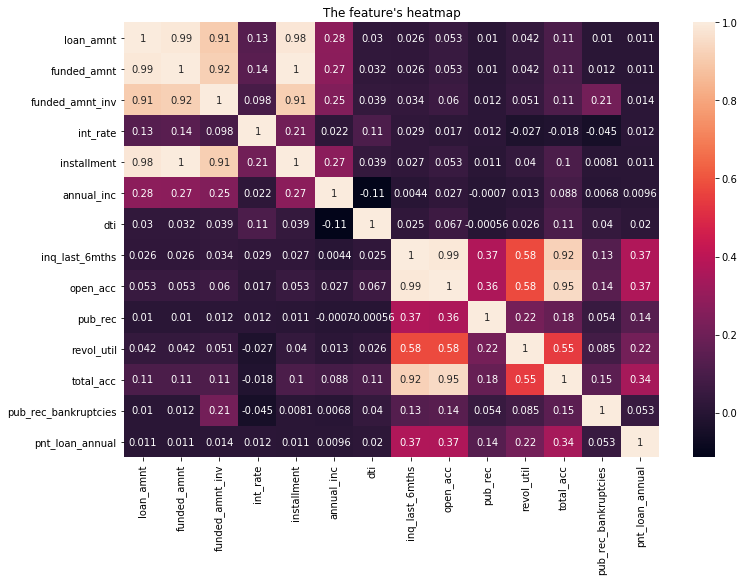

删除特征字段： 5 
 ['loan_amnt', 'total_acc', 'funded_amnt', 'installment', 'open_acc']
原特征字段： 14 
 ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_util', 'total_acc', 'pub_rec_bankruptcies', 'pnt_loan_annual']
新的特征字段： 9 
 ['funded_amnt_inv', 'int_rate', 'annual_inc', 'dti', 'inq_last_6mths', 'pub_rec', 'revol_util', 'pub_rec_bankruptcies', 'pnt_loan_annual']
新的所有特征字段： 12 
 ['emp_length', 'purpose', 'addr_state', 'funded_amnt_inv', 'int_rate', 'annual_inc', 'dti', 'inq_last_6mths', 'pub_rec', 'revol_util', 'pub_rec_bankruptcies', 'pnt_loan_annual']


In [24]:
# 3.2 根据相关性与iv筛选特征(连续性特征)
# 注：相关性高的两个特征(阈值0.7)，可删除iv值较小的特征
# 相关性分析：连续性特征(14个)
sub_num_feature = list(df_s[sel_feature_])[3:]
sub_char_feature = list(df_s[sel_feature_])[0:3]
sn_df = df_s[sub_num_feature].corr()
# 热力图
plot_seaborn(sn_df)
numf_vi = feature_sels_vi[3:].reset_index().drop('index', axis=1)

# 可删除特征字段
del_feature_subs = del_feature_sub(sn_df, numf_vi, th_c=0.7)
print('删除特征字段：', len(del_feature_subs), '\n', del_feature_subs)
print('原特征字段：', len(sub_num_feature), '\n', sub_num_feature)
# 新的连续特征字段
new_num_feature = [i for i in sub_num_feature if i not in del_feature_subs]
print('新的特征字段：',len(new_num_feature), '\n', new_num_feature)
# 新的所有特征字段
all_newFeature_sub = sub_char_feature + new_num_feature
print('新的所有特征字段：',len(all_newFeature_sub), '\n', all_newFeature_sub)

In [25]:
# 3.3 根据多重共线性筛选特征(连续型特征)
# 判断：
#    若VIF<3：说明基本不存在多重共线性的问题；
#    若3<VIF<10：存在一定的多重共线性，实情考虑；
#    若VIF>=10：说明问题比较严重，建议删除特征；
vif_df = df_s[new_num_feature]
print(vif_df.shape)
numF_vif = pd.DataFrame()
numF_vif['feature_name'] = vif_df.columns
numF_vif['vif_v'] = [variance_inflation_factor(vif_df.values, i) for i in range(vif_df.shape[1])]
print('最大VIF值：max(vif)=%s\n' % max(numF_vif.vif_v))  # max(vif_v)<10，均无多重共线性，不操作
numF_vif

(31534, 9)
最大VIF值：max(vif)=5.8973037330539



,feature_name,vif_v
0,funded_amnt_inv,3.227471
1,int_rate,5.897304
2,annual_inc,2.171382
3,dti,4.108529
4,inq_last_6mths,1.841611
5,pub_rec,1.158956
6,revol_util,1.515761
7,pub_rec_bankruptcies,1.117218
8,pnt_loan_annual,1.159677


# 4.模型建立与评价

In [26]:
# 数据准备_all_newFeature_sub
df_model = df_s[all_newFeature_sub]
df_model[sub_char_feature] = df_model[sub_char_feature].astype('str')
print(df_model.shape)

(31534, 12)


C:\Users\15742\Anaconda35\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [27]:
# 评价指标
def model_performance(y_train, pre_train, pro_train, y_test, pre_test, pro_test, plot=True):
    # 训练集
    print('Train:')
    fpr0, tpr0, th0 = roc_curve(y_train, pro_train)
    roc_auc0 = auc(fpr0, tpr0)
    print('The model accuracy is {}'.format(accuracy_score(y_train, pre_train)))
    print('The model f1 is {}'.format(f1_score(y_train, pre_train)))
    print('The model p is {}'.format(precision_score(y_train, pre_train)))
    print('The model recall is {}'.format(recall_score(y_train, pre_train)))
    print('The confusion matrix is:\n', confusion_matrix(y_train, pre_train))
    if plot:
        plot_roc_auc(fpr0, tpr0, roc_auc0)
    
    # 测试集
    print('Test:')
    fpr, tpr, th = roc_curve(y_test, pro_test)
    roc_auc = auc(fpr, tpr)
    print('The model accuracy is {}'.format(accuracy_score(y_test, pre_test)))
    print('The model f1 is {}'.format(f1_score(y_test, pre_test)))
    print('The model p is {}'.format(precision_score(y_test, pre_test)))
    print('The model recall is {}'.format(recall_score(y_test, pre_test)))
    print('The model KS is {}'.format(max(tpr - fpr)))
    print('The confusion matrix is:\n', confusion_matrix(y_test, pre_test))
    if plot:
        plot_roc_auc(fpr, tpr, roc_auc)
    return fpr, tpr, roc_auc

def plot_roc_auc(fpr, tpr, roc_auc):
    plt.plot(fpr, tpr, label='AUC = {}'.format(roc_auc))
    plt.title('ROC')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.legend()
    plt.plot([0,1],[0,1], c='r')
    plt.show()
    
def get_model_score(pro):
    score = 520 - 48 * np.log(pro/(1-pro))
    score = pd.Series(score).to_frame().rename(columns={0:'score'})
    return score

In [28]:
# ======== 4.1 CatBoost模型 ========

In [29]:
# 训练集和测试集划分：7：3
x_train_cb, x_test_cb, y_train_cb, y_test_cb = train_test_split(df_model, df_s['y'], test_size=0.3, random_state=10)
print(x_train_cb.shape)
print(x_test_cb.shape)
print(y_train_cb.shape)
print(y_test_cb.shape)

(22073, 12)
(9461, 12)
(22073,)
(9461,)


In [30]:
# 网格搜索策略--CatBoost
def get_params_init():
    params_init = {
        'iterations':10,
        'cat_features': [0,1,2],
        'loss_function':'Logloss',
        'depth':5,
        'subsample':0.7,
        'learning_rate':0.1,
        'l2_leaf_reg':0.1,   
    }
    return params_init

def get_tree_params():
    params = {
        'iterations':[10, 50, 100, 150, 200],
        'depth':[5, 6, 7, 8],
    }
    return params

def get_subsample_params():
    params = {
        'subsample':[0.5,0.6,0.7,0.8],
    }
    return params

def get_learn_params():
    params = {
        'learning_rate':[0.01,0.05,0.1,0.15],
    }
    return params

def get_l2_params():
    params = {
        'l2_leaf_reg':[0.1,0.5,1,2],
    }
    return params

def grid_params_model(model, df, label):
    # 参数组合
    grid_params = [get_tree_params(), get_subsample_params(), get_learn_params(), get_l2_params()]
    for _params_ in grid_params:
        
        gcv = GridSearchCV(estimator=model, param_grid=_params_, cv=5, iid=False)
        gcv.fit(df, label)
        print(gcv.scorer_, gcv.best_params_, gcv.best_score_)
        # 参数更新
        gcv_params =  model.get_params()
        gcv_params.update(gcv.best_params_)
        model.set_params(**gcv_params)
        print('the other params!')
    return model
        
def cat_model_run(df, label):
    params_init = get_params_init()
    # 初始模型
    model_cb = cat.CatBoostClassifier(**params_init)
    print(model_cb.get_params())
    model_cb = grid_params_model(model_cb, df, label)
    return model_cb

In [33]:
# 模型训练与结果
model_cb = cat_model_run(x_train_cb, y_train_cb)
model_cb.get_params()
model_cb.fit(x_train_cb, y_train_cb)

{'iterations': 10, 'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 0.1, 'loss_function': 'Logloss', 'subsample': 0.7, 'cat_features': [0, 1, 2]}
0:	learn: 0.6390232	total: 12.6ms	remaining: 113ms
1:	learn: 0.5949206	total: 28ms	remaining: 112ms
2:	learn: 0.5574641	total: 39.1ms	remaining: 91.2ms
3:	learn: 0.5265023	total: 53.1ms	remaining: 79.7ms
4:	learn: 0.5007500	total: 65.1ms	remaining: 65.1ms
5:	learn: 0.4788720	total: 81.2ms	remaining: 54.2ms
6:	learn: 0.4605328	total: 92.1ms	remaining: 39.5ms
7:	learn: 0.4449321	total: 115ms	remaining: 28.9ms
8:	learn: 0.4317451	total: 127ms	remaining: 14.1ms
9:	learn: 0.4202584	total: 138ms	remaining: 0us
0:	learn: 0.6388659	total: 13.5ms	remaining: 121ms
1:	learn: 0.5945650	total: 27.3ms	remaining: 109ms
2:	learn: 0.5576120	total: 40.8ms	remaining: 95.3ms
3:	learn: 0.5270149	total: 52.6ms	remaining: 79ms
4:	learn: 0.5007386	total: 63.6ms	remaining: 63.6ms
5:	learn: 0.4787249	total: 73.8ms	remaining: 49.2ms
6:	learn: 0.4600380	total: 88.4ms	re

12:	learn: 0.3950370	total: 218ms	remaining: 620ms
13:	learn: 0.3886336	total: 232ms	remaining: 595ms
14:	learn: 0.3835461	total: 244ms	remaining: 569ms
15:	learn: 0.3787227	total: 257ms	remaining: 546ms
16:	learn: 0.3748470	total: 269ms	remaining: 523ms
17:	learn: 0.3714665	total: 281ms	remaining: 500ms
18:	learn: 0.3687638	total: 293ms	remaining: 478ms
19:	learn: 0.3661700	total: 305ms	remaining: 457ms
20:	learn: 0.3637208	total: 315ms	remaining: 435ms
21:	learn: 0.3616614	total: 326ms	remaining: 414ms
22:	learn: 0.3603981	total: 335ms	remaining: 393ms
23:	learn: 0.3589123	total: 345ms	remaining: 374ms
24:	learn: 0.3575956	total: 356ms	remaining: 356ms
25:	learn: 0.3564457	total: 367ms	remaining: 339ms
26:	learn: 0.3553733	total: 380ms	remaining: 324ms
27:	learn: 0.3544676	total: 392ms	remaining: 308ms
28:	learn: 0.3535736	total: 408ms	remaining: 296ms
29:	learn: 0.3525737	total: 420ms	remaining: 280ms
30:	learn: 0.3517166	total: 434ms	remaining: 266ms
31:	learn: 0.3509387	total: 447

32:	learn: 0.3481682	total: 390ms	remaining: 792ms
33:	learn: 0.3475800	total: 407ms	remaining: 791ms
34:	learn: 0.3469612	total: 418ms	remaining: 777ms
35:	learn: 0.3465519	total: 429ms	remaining: 763ms
36:	learn: 0.3459724	total: 440ms	remaining: 748ms
37:	learn: 0.3453438	total: 453ms	remaining: 739ms
38:	learn: 0.3450678	total: 466ms	remaining: 729ms
39:	learn: 0.3446247	total: 478ms	remaining: 718ms
40:	learn: 0.3443282	total: 490ms	remaining: 705ms
41:	learn: 0.3438761	total: 502ms	remaining: 693ms
42:	learn: 0.3434213	total: 512ms	remaining: 679ms
43:	learn: 0.3430640	total: 526ms	remaining: 669ms
44:	learn: 0.3427562	total: 540ms	remaining: 660ms
45:	learn: 0.3424038	total: 554ms	remaining: 651ms
46:	learn: 0.3420824	total: 571ms	remaining: 644ms
47:	learn: 0.3419386	total: 583ms	remaining: 631ms
48:	learn: 0.3417696	total: 600ms	remaining: 624ms
49:	learn: 0.3415480	total: 615ms	remaining: 615ms
50:	learn: 0.3412146	total: 630ms	remaining: 605ms
51:	learn: 0.3409485	total: 643

0:	learn: 0.6384889	total: 16.2ms	remaining: 1.61s
1:	learn: 0.5943068	total: 32.3ms	remaining: 1.58s
2:	learn: 0.5573144	total: 43.1ms	remaining: 1.39s
3:	learn: 0.5271523	total: 53.7ms	remaining: 1.29s
4:	learn: 0.5011560	total: 65.9ms	remaining: 1.25s
5:	learn: 0.4791501	total: 82ms	remaining: 1.28s
6:	learn: 0.4606222	total: 94.6ms	remaining: 1.26s
7:	learn: 0.4447476	total: 107ms	remaining: 1.23s
8:	learn: 0.4319726	total: 117ms	remaining: 1.18s
9:	learn: 0.4203951	total: 130ms	remaining: 1.17s
10:	learn: 0.4105948	total: 142ms	remaining: 1.15s
11:	learn: 0.4022940	total: 155ms	remaining: 1.14s
12:	learn: 0.3950370	total: 165ms	remaining: 1.1s
13:	learn: 0.3886336	total: 177ms	remaining: 1.08s
14:	learn: 0.3835461	total: 191ms	remaining: 1.08s
15:	learn: 0.3787227	total: 208ms	remaining: 1.09s
16:	learn: 0.3748470	total: 221ms	remaining: 1.08s
17:	learn: 0.3714665	total: 233ms	remaining: 1.06s
18:	learn: 0.3687638	total: 247ms	remaining: 1.05s
19:	learn: 0.3661700	total: 259ms	rem

61:	learn: 0.3389337	total: 724ms	remaining: 444ms
62:	learn: 0.3387691	total: 736ms	remaining: 432ms
63:	learn: 0.3385765	total: 749ms	remaining: 422ms
64:	learn: 0.3385158	total: 771ms	remaining: 415ms
65:	learn: 0.3383814	total: 783ms	remaining: 403ms
66:	learn: 0.3381479	total: 793ms	remaining: 391ms
67:	learn: 0.3379371	total: 805ms	remaining: 379ms
68:	learn: 0.3377380	total: 817ms	remaining: 367ms
69:	learn: 0.3375989	total: 832ms	remaining: 357ms
70:	learn: 0.3374479	total: 844ms	remaining: 345ms
71:	learn: 0.3371444	total: 854ms	remaining: 332ms
72:	learn: 0.3369499	total: 866ms	remaining: 320ms
73:	learn: 0.3368296	total: 876ms	remaining: 308ms
74:	learn: 0.3367165	total: 886ms	remaining: 295ms
75:	learn: 0.3366438	total: 896ms	remaining: 283ms
76:	learn: 0.3364742	total: 910ms	remaining: 272ms
77:	learn: 0.3362819	total: 921ms	remaining: 260ms
78:	learn: 0.3361067	total: 936ms	remaining: 249ms
79:	learn: 0.3359910	total: 947ms	remaining: 237ms
80:	learn: 0.3357795	total: 957

29:	learn: 0.3508219	total: 381ms	remaining: 1.52s
30:	learn: 0.3498553	total: 397ms	remaining: 1.52s
31:	learn: 0.3489866	total: 412ms	remaining: 1.52s
32:	learn: 0.3481682	total: 424ms	remaining: 1.5s
33:	learn: 0.3475800	total: 435ms	remaining: 1.48s
34:	learn: 0.3469612	total: 446ms	remaining: 1.47s
35:	learn: 0.3465519	total: 458ms	remaining: 1.45s
36:	learn: 0.3459724	total: 470ms	remaining: 1.43s
37:	learn: 0.3453438	total: 485ms	remaining: 1.43s
38:	learn: 0.3450678	total: 498ms	remaining: 1.42s
39:	learn: 0.3446247	total: 509ms	remaining: 1.4s
40:	learn: 0.3443282	total: 519ms	remaining: 1.38s
41:	learn: 0.3438761	total: 531ms	remaining: 1.36s
42:	learn: 0.3434213	total: 541ms	remaining: 1.34s
43:	learn: 0.3430640	total: 554ms	remaining: 1.33s
44:	learn: 0.3427562	total: 569ms	remaining: 1.33s
45:	learn: 0.3424038	total: 581ms	remaining: 1.31s
46:	learn: 0.3420824	total: 592ms	remaining: 1.3s
47:	learn: 0.3419386	total: 599ms	remaining: 1.27s
48:	learn: 0.3417696	total: 610ms	

41:	learn: 0.3437594	total: 566ms	remaining: 1.46s
42:	learn: 0.3432606	total: 580ms	remaining: 1.44s
43:	learn: 0.3428620	total: 591ms	remaining: 1.42s
44:	learn: 0.3426252	total: 604ms	remaining: 1.41s
45:	learn: 0.3423658	total: 618ms	remaining: 1.4s
46:	learn: 0.3421587	total: 635ms	remaining: 1.39s
47:	learn: 0.3417059	total: 648ms	remaining: 1.38s
48:	learn: 0.3414287	total: 658ms	remaining: 1.36s
49:	learn: 0.3410955	total: 673ms	remaining: 1.35s
50:	learn: 0.3409683	total: 685ms	remaining: 1.33s
51:	learn: 0.3407867	total: 697ms	remaining: 1.31s
52:	learn: 0.3405972	total: 715ms	remaining: 1.31s
53:	learn: 0.3401465	total: 726ms	remaining: 1.29s
54:	learn: 0.3399767	total: 738ms	remaining: 1.27s
55:	learn: 0.3397832	total: 753ms	remaining: 1.26s
56:	learn: 0.3395242	total: 763ms	remaining: 1.25s
57:	learn: 0.3392285	total: 778ms	remaining: 1.23s
58:	learn: 0.3390373	total: 790ms	remaining: 1.22s
59:	learn: 0.3388116	total: 800ms	remaining: 1.2s
60:	learn: 0.3386799	total: 813ms

59:	learn: 0.3403094	total: 723ms	remaining: 1.08s
60:	learn: 0.3400672	total: 742ms	remaining: 1.08s
61:	learn: 0.3398930	total: 752ms	remaining: 1.07s
62:	learn: 0.3397423	total: 764ms	remaining: 1.05s
63:	learn: 0.3394109	total: 774ms	remaining: 1.04s
64:	learn: 0.3392429	total: 785ms	remaining: 1.03s
65:	learn: 0.3390232	total: 797ms	remaining: 1.01s
66:	learn: 0.3388283	total: 808ms	remaining: 1s
67:	learn: 0.3386651	total: 818ms	remaining: 986ms
68:	learn: 0.3385125	total: 827ms	remaining: 971ms
69:	learn: 0.3383252	total: 837ms	remaining: 957ms
70:	learn: 0.3381128	total: 848ms	remaining: 943ms
71:	learn: 0.3378776	total: 859ms	remaining: 930ms
72:	learn: 0.3376691	total: 869ms	remaining: 917ms
73:	learn: 0.3374795	total: 881ms	remaining: 905ms
74:	learn: 0.3373846	total: 891ms	remaining: 891ms
75:	learn: 0.3372012	total: 905ms	remaining: 881ms
76:	learn: 0.3371142	total: 917ms	remaining: 869ms
77:	learn: 0.3368759	total: 929ms	remaining: 857ms
78:	learn: 0.3367342	total: 938ms	

77:	learn: 0.3362819	total: 901ms	remaining: 832ms
78:	learn: 0.3361067	total: 917ms	remaining: 824ms
79:	learn: 0.3359910	total: 928ms	remaining: 812ms
80:	learn: 0.3357795	total: 939ms	remaining: 800ms
81:	learn: 0.3356311	total: 950ms	remaining: 787ms
82:	learn: 0.3355329	total: 960ms	remaining: 775ms
83:	learn: 0.3353603	total: 971ms	remaining: 763ms
84:	learn: 0.3351667	total: 980ms	remaining: 749ms
85:	learn: 0.3350143	total: 992ms	remaining: 739ms
86:	learn: 0.3348332	total: 1s	remaining: 728ms
87:	learn: 0.3347062	total: 1.02s	remaining: 718ms
88:	learn: 0.3345351	total: 1.03s	remaining: 706ms
89:	learn: 0.3342938	total: 1.04s	remaining: 695ms
90:	learn: 0.3340700	total: 1.05s	remaining: 683ms
91:	learn: 0.3338583	total: 1.06s	remaining: 671ms
92:	learn: 0.3336062	total: 1.08s	remaining: 660ms
93:	learn: 0.3335086	total: 1.1s	remaining: 653ms
94:	learn: 0.3333434	total: 1.11s	remaining: 641ms
95:	learn: 0.3331552	total: 1.12s	remaining: 629ms
96:	learn: 0.3330040	total: 1.13s	r

93:	learn: 0.3318532	total: 1.08s	remaining: 645ms
94:	learn: 0.3317248	total: 1.1s	remaining: 635ms
95:	learn: 0.3315876	total: 1.11s	remaining: 623ms
96:	learn: 0.3314720	total: 1.12s	remaining: 610ms
97:	learn: 0.3313025	total: 1.13s	remaining: 598ms
98:	learn: 0.3310653	total: 1.14s	remaining: 586ms
99:	learn: 0.3308756	total: 1.15s	remaining: 574ms
100:	learn: 0.3306014	total: 1.16s	remaining: 563ms
101:	learn: 0.3305091	total: 1.17s	remaining: 551ms
102:	learn: 0.3302727	total: 1.18s	remaining: 540ms
103:	learn: 0.3300354	total: 1.2s	remaining: 529ms
104:	learn: 0.3298075	total: 1.21s	remaining: 518ms
105:	learn: 0.3296910	total: 1.22s	remaining: 507ms
106:	learn: 0.3294858	total: 1.23s	remaining: 495ms
107:	learn: 0.3292622	total: 1.24s	remaining: 484ms
108:	learn: 0.3291250	total: 1.25s	remaining: 472ms
109:	learn: 0.3289443	total: 1.27s	remaining: 461ms
110:	learn: 0.3288628	total: 1.28s	remaining: 450ms
111:	learn: 0.3286297	total: 1.29s	remaining: 438ms
112:	learn: 0.3285447

107:	learn: 0.3260286	total: 3.79s	remaining: 3.22s
108:	learn: 0.3256916	total: 3.83s	remaining: 3.19s
109:	learn: 0.3255170	total: 3.86s	remaining: 3.16s
110:	learn: 0.3252178	total: 3.9s	remaining: 3.13s
111:	learn: 0.3248801	total: 3.94s	remaining: 3.09s
112:	learn: 0.3246504	total: 3.98s	remaining: 3.07s
113:	learn: 0.3245259	total: 4.01s	remaining: 3.03s
114:	learn: 0.3243930	total: 4.05s	remaining: 3s
115:	learn: 0.3242402	total: 4.09s	remaining: 2.96s
116:	learn: 0.3239448	total: 4.13s	remaining: 2.93s
117:	learn: 0.3236410	total: 4.17s	remaining: 2.9s
118:	learn: 0.3232992	total: 4.21s	remaining: 2.86s
119:	learn: 0.3230140	total: 4.24s	remaining: 2.83s
120:	learn: 0.3228814	total: 4.27s	remaining: 2.79s
121:	learn: 0.3227988	total: 4.31s	remaining: 2.75s
122:	learn: 0.3226963	total: 4.35s	remaining: 2.72s
123:	learn: 0.3226052	total: 4.38s	remaining: 2.69s
124:	learn: 0.3224855	total: 4.42s	remaining: 2.65s
125:	learn: 0.3223465	total: 4.45s	remaining: 2.62s
126:	learn: 0.322

68:	learn: 0.3342556	total: 2.39s	remaining: 4.54s
69:	learn: 0.3340470	total: 2.42s	remaining: 4.49s
70:	learn: 0.3338697	total: 2.45s	remaining: 4.45s
71:	learn: 0.3337433	total: 2.48s	remaining: 4.42s
72:	learn: 0.3335255	total: 2.52s	remaining: 4.38s
73:	learn: 0.3334199	total: 2.54s	remaining: 4.33s
74:	learn: 0.3332015	total: 2.58s	remaining: 4.3s
75:	learn: 0.3329092	total: 2.61s	remaining: 4.26s
76:	learn: 0.3327194	total: 2.64s	remaining: 4.22s
77:	learn: 0.3324298	total: 2.68s	remaining: 4.19s
78:	learn: 0.3322199	total: 2.71s	remaining: 4.15s
79:	learn: 0.3321085	total: 2.74s	remaining: 4.11s
80:	learn: 0.3319013	total: 2.78s	remaining: 4.08s
81:	learn: 0.3317844	total: 2.81s	remaining: 4.04s
82:	learn: 0.3316630	total: 2.85s	remaining: 4.01s
83:	learn: 0.3313350	total: 2.88s	remaining: 3.98s
84:	learn: 0.3312425	total: 2.91s	remaining: 3.93s
85:	learn: 0.3310218	total: 2.94s	remaining: 3.9s
86:	learn: 0.3308414	total: 2.98s	remaining: 3.86s
87:	learn: 0.3307067	total: 3.01s

28:	learn: 0.3480040	total: 1.03s	remaining: 6.05s
29:	learn: 0.3475272	total: 1.06s	remaining: 6.04s
30:	learn: 0.3468420	total: 1.09s	remaining: 5.97s
31:	learn: 0.3464843	total: 1.13s	remaining: 5.93s
32:	learn: 0.3463310	total: 1.15s	remaining: 5.82s
33:	learn: 0.3458267	total: 1.18s	remaining: 5.77s
34:	learn: 0.3454524	total: 1.22s	remaining: 5.76s
35:	learn: 0.3450675	total: 1.25s	remaining: 5.7s
36:	learn: 0.3447044	total: 1.28s	remaining: 5.66s
37:	learn: 0.3441218	total: 1.32s	remaining: 5.62s
38:	learn: 0.3436883	total: 1.35s	remaining: 5.59s
39:	learn: 0.3433973	total: 1.38s	remaining: 5.54s
40:	learn: 0.3430578	total: 1.42s	remaining: 5.52s
41:	learn: 0.3429094	total: 1.45s	remaining: 5.46s
42:	learn: 0.3424362	total: 1.49s	remaining: 5.44s
43:	learn: 0.3420572	total: 1.52s	remaining: 5.4s
44:	learn: 0.3416926	total: 1.56s	remaining: 5.39s
45:	learn: 0.3414797	total: 1.6s	remaining: 5.37s
46:	learn: 0.3411101	total: 1.63s	remaining: 5.32s
47:	learn: 0.3408156	total: 1.67s	

188:	learn: 0.3124817	total: 6.83s	remaining: 398ms
189:	learn: 0.3120896	total: 6.88s	remaining: 362ms
190:	learn: 0.3120234	total: 6.91s	remaining: 326ms
191:	learn: 0.3118699	total: 6.94s	remaining: 289ms
192:	learn: 0.3117196	total: 6.98s	remaining: 253ms
193:	learn: 0.3116490	total: 7.03s	remaining: 217ms
194:	learn: 0.3115089	total: 7.07s	remaining: 181ms
195:	learn: 0.3113037	total: 7.11s	remaining: 145ms
196:	learn: 0.3110750	total: 7.14s	remaining: 109ms
197:	learn: 0.3109396	total: 7.18s	remaining: 72.5ms
198:	learn: 0.3106843	total: 7.22s	remaining: 36.3ms
199:	learn: 0.3104856	total: 7.27s	remaining: 0us
0:	learn: 0.6185041	total: 62.2ms	remaining: 12.4s
1:	learn: 0.5639345	total: 104ms	remaining: 10.3s
2:	learn: 0.5186560	total: 138ms	remaining: 9.09s
3:	learn: 0.4848847	total: 180ms	remaining: 8.8s
4:	learn: 0.4578209	total: 215ms	remaining: 8.38s
5:	learn: 0.4369777	total: 254ms	remaining: 8.21s
6:	learn: 0.4195958	total: 297ms	remaining: 8.19s
7:	learn: 0.4064412	total:

151:	learn: 0.3176212	total: 5.5s	remaining: 1.74s
152:	learn: 0.3173951	total: 5.54s	remaining: 1.7s
153:	learn: 0.3172500	total: 5.57s	remaining: 1.66s
154:	learn: 0.3170951	total: 5.6s	remaining: 1.63s
155:	learn: 0.3169719	total: 5.64s	remaining: 1.59s
156:	learn: 0.3167578	total: 5.68s	remaining: 1.56s
157:	learn: 0.3165460	total: 5.72s	remaining: 1.52s
158:	learn: 0.3163713	total: 5.76s	remaining: 1.49s
159:	learn: 0.3162069	total: 5.8s	remaining: 1.45s
160:	learn: 0.3160101	total: 5.83s	remaining: 1.41s
161:	learn: 0.3156446	total: 5.86s	remaining: 1.37s
162:	learn: 0.3154732	total: 5.9s	remaining: 1.34s
163:	learn: 0.3153602	total: 5.92s	remaining: 1.3s
164:	learn: 0.3152052	total: 5.96s	remaining: 1.26s
165:	learn: 0.3150096	total: 6s	remaining: 1.23s
166:	learn: 0.3149275	total: 6.03s	remaining: 1.19s
167:	learn: 0.3147382	total: 6.07s	remaining: 1.16s
168:	learn: 0.3145731	total: 6.1s	remaining: 1.12s
169:	learn: 0.3142837	total: 6.14s	remaining: 1.08s
170:	learn: 0.3141239	

115:	learn: 0.3239963	total: 4.13s	remaining: 2.99s
116:	learn: 0.3236717	total: 4.17s	remaining: 2.96s
117:	learn: 0.3235068	total: 4.21s	remaining: 2.92s
118:	learn: 0.3232245	total: 4.25s	remaining: 2.89s
119:	learn: 0.3230626	total: 4.32s	remaining: 2.88s
120:	learn: 0.3228052	total: 4.36s	remaining: 2.85s
121:	learn: 0.3226411	total: 4.41s	remaining: 2.82s
122:	learn: 0.3224635	total: 4.45s	remaining: 2.79s
123:	learn: 0.3223069	total: 4.49s	remaining: 2.75s
124:	learn: 0.3220868	total: 4.52s	remaining: 2.71s
125:	learn: 0.3218030	total: 4.56s	remaining: 2.68s
126:	learn: 0.3215942	total: 4.6s	remaining: 2.64s
127:	learn: 0.3215273	total: 4.62s	remaining: 2.6s
128:	learn: 0.3212003	total: 4.66s	remaining: 2.56s
129:	learn: 0.3211358	total: 4.7s	remaining: 2.53s
130:	learn: 0.3209494	total: 4.74s	remaining: 2.5s
131:	learn: 0.3207261	total: 4.77s	remaining: 2.46s
132:	learn: 0.3204064	total: 4.8s	remaining: 2.42s
133:	learn: 0.3203539	total: 4.84s	remaining: 2.38s
134:	learn: 0.320

25:	learn: 0.3529722	total: 384ms	remaining: 354ms
26:	learn: 0.3514545	total: 398ms	remaining: 339ms
27:	learn: 0.3502455	total: 413ms	remaining: 325ms
28:	learn: 0.3491417	total: 429ms	remaining: 311ms
29:	learn: 0.3481155	total: 444ms	remaining: 296ms
30:	learn: 0.3471484	total: 457ms	remaining: 280ms
31:	learn: 0.3463247	total: 469ms	remaining: 264ms
32:	learn: 0.3454175	total: 483ms	remaining: 249ms
33:	learn: 0.3451894	total: 490ms	remaining: 231ms
34:	learn: 0.3444751	total: 501ms	remaining: 215ms
35:	learn: 0.3440066	total: 516ms	remaining: 201ms
36:	learn: 0.3434176	total: 528ms	remaining: 185ms
37:	learn: 0.3427735	total: 541ms	remaining: 171ms
38:	learn: 0.3422243	total: 555ms	remaining: 157ms
39:	learn: 0.3418282	total: 571ms	remaining: 143ms
40:	learn: 0.3413126	total: 590ms	remaining: 129ms
41:	learn: 0.3408677	total: 605ms	remaining: 115ms
42:	learn: 0.3404401	total: 621ms	remaining: 101ms
43:	learn: 0.3399220	total: 633ms	remaining: 86.4ms
44:	learn: 0.3395213	total: 64

39:	learn: 0.3429486	total: 565ms	remaining: 141ms
40:	learn: 0.3424558	total: 581ms	remaining: 128ms
41:	learn: 0.3419451	total: 594ms	remaining: 113ms
42:	learn: 0.3415605	total: 608ms	remaining: 98.9ms
43:	learn: 0.3410035	total: 622ms	remaining: 84.8ms
44:	learn: 0.3407052	total: 634ms	remaining: 70.5ms
45:	learn: 0.3403954	total: 647ms	remaining: 56.2ms
46:	learn: 0.3400001	total: 659ms	remaining: 42.1ms
47:	learn: 0.3398707	total: 666ms	remaining: 27.8ms
48:	learn: 0.3393543	total: 678ms	remaining: 13.8ms
49:	learn: 0.3390181	total: 696ms	remaining: 0us
0:	learn: 0.6384151	total: 16.5ms	remaining: 810ms
1:	learn: 0.5935139	total: 31.2ms	remaining: 748ms
2:	learn: 0.5564833	total: 45.4ms	remaining: 712ms
3:	learn: 0.5253410	total: 61.5ms	remaining: 708ms
4:	learn: 0.4992331	total: 74.1ms	remaining: 667ms
5:	learn: 0.4773701	total: 91.6ms	remaining: 672ms
6:	learn: 0.4584145	total: 107ms	remaining: 655ms
7:	learn: 0.4431182	total: 119ms	remaining: 627ms
8:	learn: 0.4296892	total: 1

0:	learn: 0.6388510	total: 16.9ms	remaining: 1.67s
1:	learn: 0.5939090	total: 33.7ms	remaining: 1.65s
2:	learn: 0.5567583	total: 49.3ms	remaining: 1.59s
3:	learn: 0.5255251	total: 66.5ms	remaining: 1.59s
4:	learn: 0.4996084	total: 80.2ms	remaining: 1.52s
5:	learn: 0.4777872	total: 93.9ms	remaining: 1.47s
6:	learn: 0.4587019	total: 108ms	remaining: 1.43s
7:	learn: 0.4431372	total: 121ms	remaining: 1.39s
8:	learn: 0.4295756	total: 133ms	remaining: 1.34s
9:	learn: 0.4183222	total: 147ms	remaining: 1.33s
10:	learn: 0.4087400	total: 167ms	remaining: 1.35s
11:	learn: 0.4005320	total: 183ms	remaining: 1.34s
12:	learn: 0.3933230	total: 197ms	remaining: 1.32s
13:	learn: 0.3870925	total: 212ms	remaining: 1.3s
14:	learn: 0.3817199	total: 232ms	remaining: 1.32s
15:	learn: 0.3773406	total: 247ms	remaining: 1.29s
16:	learn: 0.3734138	total: 259ms	remaining: 1.26s
17:	learn: 0.3697429	total: 272ms	remaining: 1.24s
18:	learn: 0.3668402	total: 286ms	remaining: 1.22s
19:	learn: 0.3642045	total: 299ms	re

64:	learn: 0.3340146	total: 928ms	remaining: 500ms
65:	learn: 0.3338608	total: 950ms	remaining: 490ms
66:	learn: 0.3336829	total: 965ms	remaining: 475ms
67:	learn: 0.3335132	total: 978ms	remaining: 460ms
68:	learn: 0.3333513	total: 990ms	remaining: 445ms
69:	learn: 0.3331674	total: 1s	remaining: 430ms
70:	learn: 0.3330763	total: 1.02s	remaining: 415ms
71:	learn: 0.3330316	total: 1.03s	remaining: 400ms
72:	learn: 0.3326510	total: 1.04s	remaining: 385ms
73:	learn: 0.3324955	total: 1.05s	remaining: 370ms
74:	learn: 0.3323550	total: 1.07s	remaining: 356ms
75:	learn: 0.3320257	total: 1.08s	remaining: 342ms
76:	learn: 0.3317306	total: 1.1s	remaining: 328ms
77:	learn: 0.3312812	total: 1.11s	remaining: 314ms
78:	learn: 0.3311530	total: 1.13s	remaining: 300ms
79:	learn: 0.3308448	total: 1.14s	remaining: 286ms
80:	learn: 0.3305894	total: 1.16s	remaining: 271ms
81:	learn: 0.3303471	total: 1.17s	remaining: 257ms
82:	learn: 0.3302583	total: 1.19s	remaining: 243ms
83:	learn: 0.3302545	total: 1.19s	r

26:	learn: 0.3519655	total: 386ms	remaining: 1.04s
27:	learn: 0.3505556	total: 402ms	remaining: 1.03s
28:	learn: 0.3494997	total: 415ms	remaining: 1.01s
29:	learn: 0.3487126	total: 428ms	remaining: 999ms
30:	learn: 0.3476512	total: 443ms	remaining: 986ms
31:	learn: 0.3467060	total: 455ms	remaining: 967ms
32:	learn: 0.3459277	total: 471ms	remaining: 956ms
33:	learn: 0.3452085	total: 485ms	remaining: 942ms
34:	learn: 0.3444628	total: 498ms	remaining: 924ms
35:	learn: 0.3437633	total: 510ms	remaining: 907ms
36:	learn: 0.3430629	total: 523ms	remaining: 891ms
37:	learn: 0.3424037	total: 538ms	remaining: 878ms
38:	learn: 0.3419273	total: 554ms	remaining: 866ms
39:	learn: 0.3414730	total: 573ms	remaining: 859ms
40:	learn: 0.3410260	total: 588ms	remaining: 846ms
41:	learn: 0.3403966	total: 601ms	remaining: 830ms
42:	learn: 0.3397873	total: 616ms	remaining: 817ms
43:	learn: 0.3392737	total: 629ms	remaining: 801ms
44:	learn: 0.3387912	total: 643ms	remaining: 786ms
45:	learn: 0.3382005	total: 658

90:	learn: 0.3259653	total: 1.28s	remaining: 830ms
91:	learn: 0.3256518	total: 1.29s	remaining: 817ms
92:	learn: 0.3252477	total: 1.31s	remaining: 804ms
93:	learn: 0.3250236	total: 1.32s	remaining: 789ms
94:	learn: 0.3248521	total: 1.34s	remaining: 774ms
95:	learn: 0.3244977	total: 1.35s	remaining: 760ms
96:	learn: 0.3242264	total: 1.36s	remaining: 746ms
97:	learn: 0.3241179	total: 1.38s	remaining: 732ms
98:	learn: 0.3238093	total: 1.39s	remaining: 718ms
99:	learn: 0.3234061	total: 1.41s	remaining: 703ms
100:	learn: 0.3231968	total: 1.42s	remaining: 688ms
101:	learn: 0.3229676	total: 1.43s	remaining: 675ms
102:	learn: 0.3226652	total: 1.45s	remaining: 662ms
103:	learn: 0.3223732	total: 1.47s	remaining: 648ms
104:	learn: 0.3221699	total: 1.48s	remaining: 634ms
105:	learn: 0.3218844	total: 1.49s	remaining: 620ms
106:	learn: 0.3216804	total: 1.5s	remaining: 605ms
107:	learn: 0.3214200	total: 1.52s	remaining: 590ms
108:	learn: 0.3211151	total: 1.53s	remaining: 578ms
109:	learn: 0.3208667	t

103:	learn: 0.3229113	total: 1.47s	remaining: 652ms
104:	learn: 0.3226603	total: 1.49s	remaining: 640ms
105:	learn: 0.3225430	total: 1.51s	remaining: 626ms
106:	learn: 0.3224057	total: 1.52s	remaining: 612ms
107:	learn: 0.3221389	total: 1.54s	remaining: 598ms
108:	learn: 0.3219955	total: 1.55s	remaining: 584ms
109:	learn: 0.3217423	total: 1.57s	remaining: 570ms
110:	learn: 0.3215586	total: 1.58s	remaining: 555ms
111:	learn: 0.3212734	total: 1.59s	remaining: 541ms
112:	learn: 0.3208794	total: 1.61s	remaining: 526ms
113:	learn: 0.3207721	total: 1.62s	remaining: 512ms
114:	learn: 0.3203631	total: 1.63s	remaining: 498ms
115:	learn: 0.3202379	total: 1.65s	remaining: 483ms
116:	learn: 0.3199653	total: 1.67s	remaining: 470ms
117:	learn: 0.3197469	total: 1.68s	remaining: 456ms
118:	learn: 0.3194673	total: 1.7s	remaining: 442ms
119:	learn: 0.3191647	total: 1.71s	remaining: 427ms
120:	learn: 0.3189975	total: 1.72s	remaining: 413ms
121:	learn: 0.3188168	total: 1.74s	remaining: 399ms
122:	learn: 0

114:	learn: 0.3217338	total: 1.63s	remaining: 497ms
115:	learn: 0.3212845	total: 1.65s	remaining: 484ms
116:	learn: 0.3212006	total: 1.67s	remaining: 470ms
117:	learn: 0.3208892	total: 1.68s	remaining: 456ms
118:	learn: 0.3205660	total: 1.7s	remaining: 442ms
119:	learn: 0.3201844	total: 1.71s	remaining: 427ms
120:	learn: 0.3199796	total: 1.72s	remaining: 413ms
121:	learn: 0.3197930	total: 1.74s	remaining: 399ms
122:	learn: 0.3195560	total: 1.75s	remaining: 384ms
123:	learn: 0.3193125	total: 1.76s	remaining: 370ms
124:	learn: 0.3189922	total: 1.78s	remaining: 356ms
125:	learn: 0.3188877	total: 1.79s	remaining: 342ms
126:	learn: 0.3186872	total: 1.81s	remaining: 328ms
127:	learn: 0.3184877	total: 1.82s	remaining: 313ms
128:	learn: 0.3182886	total: 1.84s	remaining: 299ms
129:	learn: 0.3179921	total: 1.85s	remaining: 285ms
130:	learn: 0.3178559	total: 1.86s	remaining: 271ms
131:	learn: 0.3176280	total: 1.88s	remaining: 257ms
132:	learn: 0.3174559	total: 1.9s	remaining: 242ms
133:	learn: 0.

128:	learn: 0.3179550	total: 1.79s	remaining: 291ms
129:	learn: 0.3177080	total: 1.8s	remaining: 278ms
130:	learn: 0.3174526	total: 1.82s	remaining: 264ms
131:	learn: 0.3172027	total: 1.83s	remaining: 250ms
132:	learn: 0.3168092	total: 1.85s	remaining: 236ms
133:	learn: 0.3166024	total: 1.86s	remaining: 222ms
134:	learn: 0.3164224	total: 1.88s	remaining: 208ms
135:	learn: 0.3162347	total: 1.89s	remaining: 194ms
136:	learn: 0.3159484	total: 1.9s	remaining: 180ms
137:	learn: 0.3157838	total: 1.92s	remaining: 167ms
138:	learn: 0.3153928	total: 1.93s	remaining: 153ms
139:	learn: 0.3150734	total: 1.95s	remaining: 139ms
140:	learn: 0.3148172	total: 1.96s	remaining: 125ms
141:	learn: 0.3144873	total: 1.98s	remaining: 112ms
142:	learn: 0.3141661	total: 2s	remaining: 97.7ms
143:	learn: 0.3139118	total: 2.01s	remaining: 83.8ms
144:	learn: 0.3137474	total: 2.02s	remaining: 69.8ms
145:	learn: 0.3135826	total: 2.04s	remaining: 55.8ms
146:	learn: 0.3133316	total: 2.05s	remaining: 41.8ms
147:	learn: 

141:	learn: 0.3129637	total: 2.19s	remaining: 123ms
142:	learn: 0.3126546	total: 2.21s	remaining: 108ms
143:	learn: 0.3124282	total: 2.22s	remaining: 92.5ms
144:	learn: 0.3122534	total: 2.23s	remaining: 77ms
145:	learn: 0.3118896	total: 2.25s	remaining: 61.5ms
146:	learn: 0.3116694	total: 2.26s	remaining: 46.1ms
147:	learn: 0.3111877	total: 2.27s	remaining: 30.7ms
148:	learn: 0.3109216	total: 2.29s	remaining: 15.4ms
149:	learn: 0.3107595	total: 2.3s	remaining: 0us
0:	learn: 0.6217807	total: 53.2ms	remaining: 10.6s
1:	learn: 0.5639143	total: 99.1ms	remaining: 9.81s
2:	learn: 0.5174156	total: 145ms	remaining: 9.54s
3:	learn: 0.4814549	total: 190ms	remaining: 9.3s
4:	learn: 0.4547977	total: 235ms	remaining: 9.17s
5:	learn: 0.4324764	total: 288ms	remaining: 9.31s
6:	learn: 0.4169009	total: 331ms	remaining: 9.13s
7:	learn: 0.4049589	total: 348ms	remaining: 8.34s
8:	learn: 0.3942621	total: 390ms	remaining: 8.28s
9:	learn: 0.3851350	total: 439ms	remaining: 8.33s
10:	learn: 0.3775892	total: 48

153:	learn: 0.2990550	total: 6.73s	remaining: 2.01s
154:	learn: 0.2986620	total: 6.77s	remaining: 1.97s
155:	learn: 0.2985428	total: 6.81s	remaining: 1.92s
156:	learn: 0.2983745	total: 6.85s	remaining: 1.88s
157:	learn: 0.2981556	total: 6.89s	remaining: 1.83s
158:	learn: 0.2979826	total: 6.94s	remaining: 1.79s
159:	learn: 0.2976719	total: 6.98s	remaining: 1.75s
160:	learn: 0.2974117	total: 7.03s	remaining: 1.7s
161:	learn: 0.2970173	total: 7.07s	remaining: 1.66s
162:	learn: 0.2968316	total: 7.12s	remaining: 1.61s
163:	learn: 0.2962852	total: 7.16s	remaining: 1.57s
164:	learn: 0.2960879	total: 7.2s	remaining: 1.53s
165:	learn: 0.2956915	total: 7.25s	remaining: 1.49s
166:	learn: 0.2954707	total: 7.3s	remaining: 1.44s
167:	learn: 0.2952458	total: 7.35s	remaining: 1.4s
168:	learn: 0.2949621	total: 7.39s	remaining: 1.36s
169:	learn: 0.2945365	total: 7.44s	remaining: 1.31s
170:	learn: 0.2942911	total: 7.48s	remaining: 1.27s
171:	learn: 0.2938298	total: 7.53s	remaining: 1.23s
172:	learn: 0.29

118:	learn: 0.3106787	total: 5.14s	remaining: 3.5s
119:	learn: 0.3104078	total: 5.18s	remaining: 3.46s
120:	learn: 0.3100638	total: 5.22s	remaining: 3.41s
121:	learn: 0.3097817	total: 5.26s	remaining: 3.37s
122:	learn: 0.3094592	total: 5.31s	remaining: 3.32s
123:	learn: 0.3091932	total: 5.35s	remaining: 3.28s
124:	learn: 0.3089020	total: 5.39s	remaining: 3.23s
125:	learn: 0.3086103	total: 5.43s	remaining: 3.19s
126:	learn: 0.3084083	total: 5.48s	remaining: 3.15s
127:	learn: 0.3081550	total: 5.52s	remaining: 3.1s
128:	learn: 0.3076870	total: 5.57s	remaining: 3.07s
129:	learn: 0.3074761	total: 5.6s	remaining: 3.02s
130:	learn: 0.3071324	total: 5.64s	remaining: 2.97s
131:	learn: 0.3068724	total: 5.68s	remaining: 2.92s
132:	learn: 0.3065307	total: 5.72s	remaining: 2.88s
133:	learn: 0.3062990	total: 5.76s	remaining: 2.84s
134:	learn: 0.3060643	total: 5.8s	remaining: 2.79s
135:	learn: 0.3058148	total: 5.84s	remaining: 2.75s
136:	learn: 0.3054361	total: 5.89s	remaining: 2.71s
137:	learn: 0.30

80:	learn: 0.3233459	total: 3.59s	remaining: 5.27s
81:	learn: 0.3230902	total: 3.63s	remaining: 5.22s
82:	learn: 0.3228159	total: 3.67s	remaining: 5.17s
83:	learn: 0.3225062	total: 3.72s	remaining: 5.13s
84:	learn: 0.3220632	total: 3.76s	remaining: 5.09s
85:	learn: 0.3218195	total: 3.81s	remaining: 5.04s
86:	learn: 0.3214008	total: 3.85s	remaining: 5s
87:	learn: 0.3211160	total: 3.89s	remaining: 4.95s
88:	learn: 0.3207356	total: 3.94s	remaining: 4.91s
89:	learn: 0.3203142	total: 3.98s	remaining: 4.87s
90:	learn: 0.3200535	total: 4.04s	remaining: 4.83s
91:	learn: 0.3197734	total: 4.08s	remaining: 4.79s
92:	learn: 0.3195594	total: 4.12s	remaining: 4.74s
93:	learn: 0.3194441	total: 4.16s	remaining: 4.69s
94:	learn: 0.3191651	total: 4.2s	remaining: 4.64s
95:	learn: 0.3189249	total: 4.24s	remaining: 4.6s
96:	learn: 0.3186046	total: 4.28s	remaining: 4.54s
97:	learn: 0.3183342	total: 4.32s	remaining: 4.49s
98:	learn: 0.3181577	total: 4.35s	remaining: 4.44s
99:	learn: 0.3180066	total: 4.41s	re

42:	learn: 0.3355757	total: 1.91s	remaining: 6.98s
43:	learn: 0.3351549	total: 1.95s	remaining: 6.93s
44:	learn: 0.3348084	total: 1.99s	remaining: 6.85s
45:	learn: 0.3344249	total: 2.03s	remaining: 6.79s
46:	learn: 0.3340082	total: 2.06s	remaining: 6.72s
47:	learn: 0.3336413	total: 2.12s	remaining: 6.71s
48:	learn: 0.3331411	total: 2.17s	remaining: 6.68s
49:	learn: 0.3327644	total: 2.21s	remaining: 6.62s
50:	learn: 0.3325289	total: 2.25s	remaining: 6.58s
51:	learn: 0.3322759	total: 2.3s	remaining: 6.54s
52:	learn: 0.3318750	total: 2.34s	remaining: 6.49s
53:	learn: 0.3314696	total: 2.39s	remaining: 6.46s
54:	learn: 0.3311569	total: 2.43s	remaining: 6.41s
55:	learn: 0.3308020	total: 2.48s	remaining: 6.39s
56:	learn: 0.3302735	total: 2.53s	remaining: 6.34s
57:	learn: 0.3299845	total: 2.57s	remaining: 6.3s
58:	learn: 0.3296038	total: 2.62s	remaining: 6.27s
59:	learn: 0.3292882	total: 2.67s	remaining: 6.24s
60:	learn: 0.3288067	total: 2.71s	remaining: 6.18s
61:	learn: 0.3284287	total: 2.75s

5:	learn: 0.4331011	total: 290ms	remaining: 9.37s
6:	learn: 0.4158619	total: 334ms	remaining: 9.2s
7:	learn: 0.4044116	total: 350ms	remaining: 8.41s
8:	learn: 0.3940780	total: 394ms	remaining: 8.35s
9:	learn: 0.3860866	total: 438ms	remaining: 8.32s
10:	learn: 0.3797134	total: 484ms	remaining: 8.31s
11:	learn: 0.3743350	total: 530ms	remaining: 8.29s
12:	learn: 0.3687152	total: 575ms	remaining: 8.27s
13:	learn: 0.3645009	total: 627ms	remaining: 8.33s
14:	learn: 0.3613421	total: 685ms	remaining: 8.45s
15:	learn: 0.3588227	total: 732ms	remaining: 8.41s
16:	learn: 0.3575606	total: 745ms	remaining: 8.02s
17:	learn: 0.3551288	total: 793ms	remaining: 8.02s
18:	learn: 0.3533118	total: 843ms	remaining: 8.03s
19:	learn: 0.3518526	total: 881ms	remaining: 7.93s
20:	learn: 0.3508121	total: 919ms	remaining: 7.83s
21:	learn: 0.3494473	total: 965ms	remaining: 7.81s
22:	learn: 0.3482306	total: 1.01s	remaining: 7.77s
23:	learn: 0.3471068	total: 1.05s	remaining: 7.71s
24:	learn: 0.3460221	total: 1.11s	rem

165:	learn: 0.2978164	total: 8.12s	remaining: 1.66s
166:	learn: 0.2975677	total: 8.16s	remaining: 1.61s
167:	learn: 0.2971058	total: 8.21s	remaining: 1.56s
168:	learn: 0.2968161	total: 8.26s	remaining: 1.51s
169:	learn: 0.2964613	total: 8.3s	remaining: 1.47s
170:	learn: 0.2963039	total: 8.35s	remaining: 1.42s
171:	learn: 0.2961475	total: 8.39s	remaining: 1.37s
172:	learn: 0.2957897	total: 8.45s	remaining: 1.32s
173:	learn: 0.2956207	total: 8.49s	remaining: 1.27s
174:	learn: 0.2953189	total: 8.53s	remaining: 1.22s
175:	learn: 0.2950281	total: 8.58s	remaining: 1.17s
176:	learn: 0.2947148	total: 8.63s	remaining: 1.12s
177:	learn: 0.2943424	total: 8.69s	remaining: 1.07s
178:	learn: 0.2940786	total: 8.73s	remaining: 1.02s
179:	learn: 0.2938483	total: 8.78s	remaining: 976ms
180:	learn: 0.2934686	total: 8.82s	remaining: 926ms
181:	learn: 0.2933228	total: 8.88s	remaining: 878ms
182:	learn: 0.2930374	total: 8.92s	remaining: 829ms
183:	learn: 0.2927860	total: 8.96s	remaining: 779ms
184:	learn: 0

31:	learn: 0.3428408	total: 603ms	remaining: 339ms
32:	learn: 0.3418263	total: 626ms	remaining: 323ms
33:	learn: 0.3411738	total: 644ms	remaining: 303ms
34:	learn: 0.3401262	total: 662ms	remaining: 284ms
35:	learn: 0.3391725	total: 678ms	remaining: 264ms
36:	learn: 0.3383056	total: 696ms	remaining: 245ms
37:	learn: 0.3376396	total: 714ms	remaining: 225ms
38:	learn: 0.3370093	total: 731ms	remaining: 206ms
39:	learn: 0.3363885	total: 749ms	remaining: 187ms
40:	learn: 0.3356983	total: 769ms	remaining: 169ms
41:	learn: 0.3355137	total: 783ms	remaining: 149ms
42:	learn: 0.3349139	total: 802ms	remaining: 131ms
43:	learn: 0.3342930	total: 822ms	remaining: 112ms
44:	learn: 0.3335951	total: 840ms	remaining: 93.3ms
45:	learn: 0.3332414	total: 858ms	remaining: 74.6ms
46:	learn: 0.3328323	total: 876ms	remaining: 55.9ms
47:	learn: 0.3324335	total: 898ms	remaining: 37.4ms
48:	learn: 0.3318366	total: 913ms	remaining: 18.6ms
49:	learn: 0.3310323	total: 932ms	remaining: 0us
0:	learn: 0.6384183	total: 1

0:	learn: 0.6389788	total: 19ms	remaining: 1.88s
1:	learn: 0.5937047	total: 41.8ms	remaining: 2.04s
2:	learn: 0.5566450	total: 63.3ms	remaining: 2.05s
3:	learn: 0.5249389	total: 80.4ms	remaining: 1.93s
4:	learn: 0.4990264	total: 104ms	remaining: 1.97s
5:	learn: 0.4770879	total: 121ms	remaining: 1.9s
6:	learn: 0.4580716	total: 140ms	remaining: 1.86s
7:	learn: 0.4416550	total: 157ms	remaining: 1.8s
8:	learn: 0.4280612	total: 176ms	remaining: 1.77s
9:	learn: 0.4160968	total: 195ms	remaining: 1.75s
10:	learn: 0.4059041	total: 218ms	remaining: 1.76s
11:	learn: 0.3975104	total: 235ms	remaining: 1.73s
12:	learn: 0.3902143	total: 260ms	remaining: 1.74s
13:	learn: 0.3841481	total: 278ms	remaining: 1.71s
14:	learn: 0.3787459	total: 295ms	remaining: 1.67s
15:	learn: 0.3746295	total: 313ms	remaining: 1.64s
16:	learn: 0.3706701	total: 331ms	remaining: 1.61s
17:	learn: 0.3670600	total: 351ms	remaining: 1.6s
18:	learn: 0.3637387	total: 370ms	remaining: 1.58s
19:	learn: 0.3612352	total: 392ms	remainin

70:	learn: 0.3225642	total: 1.3s	remaining: 532ms
71:	learn: 0.3225253	total: 1.32s	remaining: 512ms
72:	learn: 0.3222038	total: 1.33s	remaining: 493ms
73:	learn: 0.3218406	total: 1.35s	remaining: 475ms
74:	learn: 0.3215841	total: 1.37s	remaining: 457ms
75:	learn: 0.3210760	total: 1.39s	remaining: 438ms
76:	learn: 0.3207452	total: 1.41s	remaining: 420ms
77:	learn: 0.3206100	total: 1.42s	remaining: 401ms
78:	learn: 0.3202898	total: 1.44s	remaining: 384ms
79:	learn: 0.3199988	total: 1.46s	remaining: 366ms
80:	learn: 0.3198058	total: 1.48s	remaining: 347ms
81:	learn: 0.3195166	total: 1.5s	remaining: 330ms
82:	learn: 0.3193125	total: 1.52s	remaining: 311ms
83:	learn: 0.3191032	total: 1.54s	remaining: 293ms
84:	learn: 0.3187766	total: 1.56s	remaining: 275ms
85:	learn: 0.3183863	total: 1.57s	remaining: 256ms
86:	learn: 0.3180740	total: 1.59s	remaining: 238ms
87:	learn: 0.3175329	total: 1.61s	remaining: 220ms
88:	learn: 0.3172786	total: 1.63s	remaining: 202ms
89:	learn: 0.3169867	total: 1.65s

39:	learn: 0.3375892	total: 752ms	remaining: 1.13s
40:	learn: 0.3368784	total: 771ms	remaining: 1.11s
41:	learn: 0.3364118	total: 790ms	remaining: 1.09s
42:	learn: 0.3359437	total: 809ms	remaining: 1.07s
43:	learn: 0.3352149	total: 828ms	remaining: 1.05s
44:	learn: 0.3344205	total: 846ms	remaining: 1.03s
45:	learn: 0.3339808	total: 864ms	remaining: 1.01s
46:	learn: 0.3335397	total: 881ms	remaining: 993ms
47:	learn: 0.3330082	total: 903ms	remaining: 978ms
48:	learn: 0.3327273	total: 920ms	remaining: 957ms
49:	learn: 0.3322761	total: 945ms	remaining: 945ms
50:	learn: 0.3320392	total: 963ms	remaining: 925ms
51:	learn: 0.3315761	total: 979ms	remaining: 904ms
52:	learn: 0.3309351	total: 1s	remaining: 887ms
53:	learn: 0.3305157	total: 1.02s	remaining: 867ms
54:	learn: 0.3301453	total: 1.04s	remaining: 848ms
55:	learn: 0.3301007	total: 1.05s	remaining: 822ms
56:	learn: 0.3297484	total: 1.06s	remaining: 802ms
57:	learn: 0.3294292	total: 1.08s	remaining: 783ms
58:	learn: 0.3290505	total: 1.1s	r

11:	learn: 0.3975104	total: 221ms	remaining: 2.54s
12:	learn: 0.3902143	total: 242ms	remaining: 2.55s
13:	learn: 0.3841481	total: 260ms	remaining: 2.53s
14:	learn: 0.3787459	total: 277ms	remaining: 2.5s
15:	learn: 0.3746295	total: 295ms	remaining: 2.47s
16:	learn: 0.3706701	total: 313ms	remaining: 2.45s
17:	learn: 0.3670600	total: 331ms	remaining: 2.43s
18:	learn: 0.3637387	total: 349ms	remaining: 2.4s
19:	learn: 0.3612352	total: 366ms	remaining: 2.38s
20:	learn: 0.3592343	total: 386ms	remaining: 2.37s
21:	learn: 0.3567259	total: 405ms	remaining: 2.36s
22:	learn: 0.3547645	total: 423ms	remaining: 2.33s
23:	learn: 0.3530703	total: 439ms	remaining: 2.31s
24:	learn: 0.3517778	total: 453ms	remaining: 2.27s
25:	learn: 0.3502317	total: 469ms	remaining: 2.24s
26:	learn: 0.3484980	total: 490ms	remaining: 2.23s
27:	learn: 0.3474480	total: 509ms	remaining: 2.22s
28:	learn: 0.3462072	total: 527ms	remaining: 2.2s
29:	learn: 0.3451891	total: 547ms	remaining: 2.19s
30:	learn: 0.3443583	total: 564ms	

29:	learn: 0.3448713	total: 572ms	remaining: 2.29s
30:	learn: 0.3437913	total: 591ms	remaining: 2.27s
31:	learn: 0.3428408	total: 610ms	remaining: 2.25s
32:	learn: 0.3418263	total: 632ms	remaining: 2.24s
33:	learn: 0.3411738	total: 650ms	remaining: 2.22s
34:	learn: 0.3401262	total: 669ms	remaining: 2.2s
35:	learn: 0.3391725	total: 689ms	remaining: 2.18s
36:	learn: 0.3383056	total: 707ms	remaining: 2.16s
37:	learn: 0.3376396	total: 727ms	remaining: 2.14s
38:	learn: 0.3370093	total: 746ms	remaining: 2.12s
39:	learn: 0.3363885	total: 766ms	remaining: 2.11s
40:	learn: 0.3356983	total: 786ms	remaining: 2.09s
41:	learn: 0.3355137	total: 797ms	remaining: 2.05s
42:	learn: 0.3349139	total: 817ms	remaining: 2.03s
43:	learn: 0.3342930	total: 836ms	remaining: 2.01s
44:	learn: 0.3335951	total: 854ms	remaining: 1.99s
45:	learn: 0.3332414	total: 871ms	remaining: 1.97s
46:	learn: 0.3328323	total: 887ms	remaining: 1.94s
47:	learn: 0.3324335	total: 910ms	remaining: 1.93s
48:	learn: 0.3318366	total: 932m

40:	learn: 0.3373624	total: 778ms	remaining: 2.07s
41:	learn: 0.3366086	total: 797ms	remaining: 2.05s
42:	learn: 0.3363685	total: 816ms	remaining: 2.03s
43:	learn: 0.3356249	total: 835ms	remaining: 2.01s
44:	learn: 0.3352603	total: 853ms	remaining: 1.99s
45:	learn: 0.3345868	total: 871ms	remaining: 1.97s
46:	learn: 0.3341033	total: 889ms	remaining: 1.95s
47:	learn: 0.3336471	total: 907ms	remaining: 1.93s
48:	learn: 0.3333886	total: 925ms	remaining: 1.91s
49:	learn: 0.3333292	total: 937ms	remaining: 1.87s
50:	learn: 0.3332865	total: 946ms	remaining: 1.84s
51:	learn: 0.3328183	total: 966ms	remaining: 1.82s
52:	learn: 0.3325842	total: 985ms	remaining: 1.8s
53:	learn: 0.3323205	total: 1s	remaining: 1.78s
54:	learn: 0.3320088	total: 1.02s	remaining: 1.76s
55:	learn: 0.3317189	total: 1.04s	remaining: 1.74s
56:	learn: 0.3312112	total: 1.06s	remaining: 1.73s
57:	learn: 0.3311805	total: 1.07s	remaining: 1.69s
58:	learn: 0.3307535	total: 1.08s	remaining: 1.67s
59:	learn: 0.3302145	total: 1.1s	re

51:	learn: 0.3315761	total: 985ms	remaining: 1.85s
52:	learn: 0.3309351	total: 1s	remaining: 1.84s
53:	learn: 0.3305157	total: 1.02s	remaining: 1.82s
54:	learn: 0.3301453	total: 1.04s	remaining: 1.8s
55:	learn: 0.3301007	total: 1.05s	remaining: 1.76s
56:	learn: 0.3297484	total: 1.07s	remaining: 1.75s
57:	learn: 0.3294292	total: 1.08s	remaining: 1.72s
58:	learn: 0.3290505	total: 1.1s	remaining: 1.7s
59:	learn: 0.3284199	total: 1.12s	remaining: 1.68s
60:	learn: 0.3280885	total: 1.14s	remaining: 1.66s
61:	learn: 0.3280700	total: 1.15s	remaining: 1.63s
62:	learn: 0.3276368	total: 1.17s	remaining: 1.62s
63:	learn: 0.3272290	total: 1.19s	remaining: 1.6s
64:	learn: 0.3269276	total: 1.21s	remaining: 1.58s
65:	learn: 0.3267421	total: 1.22s	remaining: 1.56s
66:	learn: 0.3261972	total: 1.24s	remaining: 1.54s
67:	learn: 0.3258729	total: 1.26s	remaining: 1.52s
68:	learn: 0.3251349	total: 1.27s	remaining: 1.5s
69:	learn: 0.3246416	total: 1.29s	remaining: 1.48s
70:	learn: 0.3246364	total: 1.3s	remain

62:	learn: 0.3289153	total: 1.14s	remaining: 1.57s
63:	learn: 0.3285238	total: 1.16s	remaining: 1.56s
64:	learn: 0.3280584	total: 1.18s	remaining: 1.54s
65:	learn: 0.3278867	total: 1.19s	remaining: 1.52s
66:	learn: 0.3277186	total: 1.21s	remaining: 1.5s
67:	learn: 0.3271466	total: 1.23s	remaining: 1.48s
68:	learn: 0.3269102	total: 1.25s	remaining: 1.47s
69:	learn: 0.3266405	total: 1.26s	remaining: 1.45s
70:	learn: 0.3262966	total: 1.28s	remaining: 1.43s
71:	learn: 0.3258673	total: 1.3s	remaining: 1.41s
72:	learn: 0.3256995	total: 1.32s	remaining: 1.39s
73:	learn: 0.3252736	total: 1.34s	remaining: 1.37s
74:	learn: 0.3246826	total: 1.36s	remaining: 1.36s
75:	learn: 0.3242747	total: 1.38s	remaining: 1.34s
76:	learn: 0.3239564	total: 1.39s	remaining: 1.32s
77:	learn: 0.3238305	total: 1.41s	remaining: 1.3s
78:	learn: 0.3237085	total: 1.43s	remaining: 1.28s
79:	learn: 0.3231679	total: 1.45s	remaining: 1.26s
80:	learn: 0.3228745	total: 1.46s	remaining: 1.25s
81:	learn: 0.3226083	total: 1.49s	

75:	learn: 0.3135891	total: 3.86s	remaining: 6.3s
76:	learn: 0.3131650	total: 3.92s	remaining: 6.26s
77:	learn: 0.3127625	total: 3.97s	remaining: 6.21s
78:	learn: 0.3120123	total: 4.03s	remaining: 6.18s
79:	learn: 0.3114422	total: 4.1s	remaining: 6.14s
80:	learn: 0.3110522	total: 4.15s	remaining: 6.1s
81:	learn: 0.3107849	total: 4.2s	remaining: 6.04s
82:	learn: 0.3104449	total: 4.25s	remaining: 6s
83:	learn: 0.3098372	total: 4.32s	remaining: 5.96s
84:	learn: 0.3094777	total: 4.38s	remaining: 5.93s
85:	learn: 0.3090541	total: 4.44s	remaining: 5.89s
86:	learn: 0.3087762	total: 4.5s	remaining: 5.84s
87:	learn: 0.3082218	total: 4.56s	remaining: 5.8s
88:	learn: 0.3079019	total: 4.61s	remaining: 5.75s
89:	learn: 0.3076077	total: 4.65s	remaining: 5.68s
90:	learn: 0.3073495	total: 4.69s	remaining: 5.61s
91:	learn: 0.3069312	total: 4.75s	remaining: 5.58s
92:	learn: 0.3065422	total: 4.81s	remaining: 5.53s
93:	learn: 0.3061752	total: 4.86s	remaining: 5.48s
94:	learn: 0.3056028	total: 4.95s	remain

35:	learn: 0.3342767	total: 1.78s	remaining: 8.09s
36:	learn: 0.3331001	total: 1.84s	remaining: 8.11s
37:	learn: 0.3326121	total: 1.9s	remaining: 8.09s
38:	learn: 0.3320020	total: 1.95s	remaining: 8.05s
39:	learn: 0.3309552	total: 2.01s	remaining: 8.05s
40:	learn: 0.3302875	total: 2.07s	remaining: 8.02s
41:	learn: 0.3297458	total: 2.12s	remaining: 7.96s
42:	learn: 0.3297068	total: 2.13s	remaining: 7.79s
43:	learn: 0.3288839	total: 2.18s	remaining: 7.72s
44:	learn: 0.3283750	total: 2.23s	remaining: 7.69s
45:	learn: 0.3283395	total: 2.25s	remaining: 7.55s
46:	learn: 0.3275915	total: 2.31s	remaining: 7.52s
47:	learn: 0.3271311	total: 2.36s	remaining: 7.48s
48:	learn: 0.3264831	total: 2.42s	remaining: 7.45s
49:	learn: 0.3257226	total: 2.48s	remaining: 7.45s
50:	learn: 0.3250410	total: 2.54s	remaining: 7.42s
51:	learn: 0.3242867	total: 2.59s	remaining: 7.38s
52:	learn: 0.3236323	total: 2.65s	remaining: 7.36s
53:	learn: 0.3232693	total: 2.7s	remaining: 7.3s
54:	learn: 0.3230375	total: 2.75s	

195:	learn: 0.2649290	total: 10.8s	remaining: 219ms
196:	learn: 0.2643367	total: 10.8s	remaining: 165ms
197:	learn: 0.2641662	total: 10.9s	remaining: 110ms
198:	learn: 0.2636897	total: 10.9s	remaining: 54.9ms
199:	learn: 0.2633158	total: 11s	remaining: 0us
0:	learn: 0.6164812	total: 63ms	remaining: 12.5s
1:	learn: 0.5569375	total: 129ms	remaining: 12.7s
2:	learn: 0.5150819	total: 169ms	remaining: 11.1s
3:	learn: 0.4828177	total: 208ms	remaining: 10.2s
4:	learn: 0.4561212	total: 268ms	remaining: 10.5s
5:	learn: 0.4360964	total: 323ms	remaining: 10.4s
6:	learn: 0.4176899	total: 379ms	remaining: 10.4s
7:	learn: 0.4052294	total: 407ms	remaining: 9.76s
8:	learn: 0.3925101	total: 473ms	remaining: 10s
9:	learn: 0.3853833	total: 507ms	remaining: 9.63s
10:	learn: 0.3771925	total: 566ms	remaining: 9.72s
11:	learn: 0.3715262	total: 621ms	remaining: 9.73s
12:	learn: 0.3677029	total: 645ms	remaining: 9.28s
13:	learn: 0.3635804	total: 696ms	remaining: 9.25s
14:	learn: 0.3605083	total: 751ms	remainin

158:	learn: 0.2781426	total: 8.78s	remaining: 2.26s
159:	learn: 0.2777745	total: 8.84s	remaining: 2.21s
160:	learn: 0.2771936	total: 8.9s	remaining: 2.16s
161:	learn: 0.2768885	total: 8.96s	remaining: 2.1s
162:	learn: 0.2765331	total: 9.02s	remaining: 2.05s
163:	learn: 0.2762041	total: 9.07s	remaining: 1.99s
164:	learn: 0.2758731	total: 9.13s	remaining: 1.94s
165:	learn: 0.2754144	total: 9.19s	remaining: 1.88s
166:	learn: 0.2748235	total: 9.25s	remaining: 1.83s
167:	learn: 0.2743757	total: 9.31s	remaining: 1.77s
168:	learn: 0.2741864	total: 9.37s	remaining: 1.72s
169:	learn: 0.2738607	total: 9.43s	remaining: 1.66s
170:	learn: 0.2736385	total: 9.49s	remaining: 1.61s
171:	learn: 0.2731824	total: 9.54s	remaining: 1.55s
172:	learn: 0.2728619	total: 9.61s	remaining: 1.5s
173:	learn: 0.2723732	total: 9.67s	remaining: 1.44s
174:	learn: 0.2723037	total: 9.72s	remaining: 1.39s
175:	learn: 0.2717597	total: 9.77s	remaining: 1.33s
176:	learn: 0.2714791	total: 9.83s	remaining: 1.28s
177:	learn: 0.2

121:	learn: 0.2907386	total: 6.71s	remaining: 4.29s
122:	learn: 0.2902552	total: 6.76s	remaining: 4.23s
123:	learn: 0.2896212	total: 6.82s	remaining: 4.18s
124:	learn: 0.2888021	total: 6.87s	remaining: 4.12s
125:	learn: 0.2880777	total: 6.93s	remaining: 4.07s
126:	learn: 0.2877349	total: 6.98s	remaining: 4.01s
127:	learn: 0.2874423	total: 7.04s	remaining: 3.96s
128:	learn: 0.2868624	total: 7.09s	remaining: 3.9s
129:	learn: 0.2863379	total: 7.16s	remaining: 3.85s
130:	learn: 0.2859563	total: 7.21s	remaining: 3.8s
131:	learn: 0.2853510	total: 7.27s	remaining: 3.75s
132:	learn: 0.2850203	total: 7.33s	remaining: 3.69s
133:	learn: 0.2846854	total: 7.39s	remaining: 3.64s
134:	learn: 0.2841591	total: 7.45s	remaining: 3.59s
135:	learn: 0.2839052	total: 7.51s	remaining: 3.53s
136:	learn: 0.2833024	total: 7.57s	remaining: 3.48s
137:	learn: 0.2830530	total: 7.63s	remaining: 3.43s
138:	learn: 0.2826681	total: 7.69s	remaining: 3.38s
139:	learn: 0.2821647	total: 7.74s	remaining: 3.32s
140:	learn: 0.

82:	learn: 0.3114157	total: 4.41s	remaining: 6.22s
83:	learn: 0.3108186	total: 4.47s	remaining: 6.17s
84:	learn: 0.3104257	total: 4.52s	remaining: 6.11s
85:	learn: 0.3096317	total: 4.58s	remaining: 6.07s
86:	learn: 0.3090313	total: 4.63s	remaining: 6.01s
87:	learn: 0.3084108	total: 4.68s	remaining: 5.96s
88:	learn: 0.3079586	total: 4.74s	remaining: 5.92s
89:	learn: 0.3073909	total: 4.8s	remaining: 5.87s
90:	learn: 0.3071973	total: 4.86s	remaining: 5.82s
91:	learn: 0.3068287	total: 4.92s	remaining: 5.78s
92:	learn: 0.3060723	total: 4.98s	remaining: 5.73s
93:	learn: 0.3057240	total: 5.04s	remaining: 5.69s
94:	learn: 0.3052229	total: 5.11s	remaining: 5.64s
95:	learn: 0.3048577	total: 5.16s	remaining: 5.59s
96:	learn: 0.3045541	total: 5.22s	remaining: 5.54s
97:	learn: 0.3041465	total: 5.28s	remaining: 5.5s
98:	learn: 0.3038011	total: 5.33s	remaining: 5.44s
99:	learn: 0.3030208	total: 5.39s	remaining: 5.39s
100:	learn: 0.3026743	total: 5.44s	remaining: 5.33s
101:	learn: 0.3020972	total: 5.5

9:	learn: 0.4166760	total: 261ms	remaining: 0us
0:	learn: 0.6389477	total: 23.3ms	remaining: 1.14s
1:	learn: 0.5935866	total: 52ms	remaining: 1.25s
2:	learn: 0.5563945	total: 79.9ms	remaining: 1.25s
3:	learn: 0.5245137	total: 107ms	remaining: 1.23s
4:	learn: 0.4985583	total: 121ms	remaining: 1.09s
5:	learn: 0.4765786	total: 145ms	remaining: 1.06s
6:	learn: 0.4574684	total: 172ms	remaining: 1.05s
7:	learn: 0.4414573	total: 191ms	remaining: 1s
8:	learn: 0.4276016	total: 215ms	remaining: 981ms
9:	learn: 0.4156377	total: 246ms	remaining: 985ms
10:	learn: 0.4052410	total: 269ms	remaining: 955ms
11:	learn: 0.3966653	total: 298ms	remaining: 942ms
12:	learn: 0.3893221	total: 326ms	remaining: 927ms
13:	learn: 0.3824852	total: 350ms	remaining: 901ms
14:	learn: 0.3772862	total: 375ms	remaining: 876ms
15:	learn: 0.3721069	total: 400ms	remaining: 849ms
16:	learn: 0.3678394	total: 431ms	remaining: 836ms
17:	learn: 0.3647084	total: 450ms	remaining: 800ms
18:	learn: 0.3617477	total: 478ms	remaining: 7

15:	learn: 0.3734676	total: 412ms	remaining: 876ms
16:	learn: 0.3690174	total: 437ms	remaining: 849ms
17:	learn: 0.3651681	total: 465ms	remaining: 827ms
18:	learn: 0.3621726	total: 490ms	remaining: 800ms
19:	learn: 0.3591651	total: 515ms	remaining: 773ms
20:	learn: 0.3561560	total: 541ms	remaining: 747ms
21:	learn: 0.3540508	total: 567ms	remaining: 722ms
22:	learn: 0.3518336	total: 598ms	remaining: 702ms
23:	learn: 0.3499170	total: 626ms	remaining: 678ms
24:	learn: 0.3481582	total: 652ms	remaining: 652ms
25:	learn: 0.3463799	total: 680ms	remaining: 627ms
26:	learn: 0.3442296	total: 706ms	remaining: 601ms
27:	learn: 0.3427950	total: 733ms	remaining: 576ms
28:	learn: 0.3416980	total: 756ms	remaining: 548ms
29:	learn: 0.3402710	total: 786ms	remaining: 524ms
30:	learn: 0.3400384	total: 796ms	remaining: 488ms
31:	learn: 0.3391223	total: 817ms	remaining: 459ms
32:	learn: 0.3384595	total: 847ms	remaining: 436ms
33:	learn: 0.3377614	total: 872ms	remaining: 410ms
34:	learn: 0.3369063	total: 897

81:	learn: 0.3045414	total: 2.14s	remaining: 471ms
82:	learn: 0.3038978	total: 2.17s	remaining: 445ms
83:	learn: 0.3034476	total: 2.2s	remaining: 418ms
84:	learn: 0.3030876	total: 2.22s	remaining: 392ms
85:	learn: 0.3029204	total: 2.25s	remaining: 366ms
86:	learn: 0.3028086	total: 2.27s	remaining: 339ms
87:	learn: 0.3023590	total: 2.3s	remaining: 313ms
88:	learn: 0.3020506	total: 2.32s	remaining: 287ms
89:	learn: 0.3013646	total: 2.35s	remaining: 262ms
90:	learn: 0.3010635	total: 2.38s	remaining: 235ms
91:	learn: 0.3003387	total: 2.4s	remaining: 209ms
92:	learn: 0.3001607	total: 2.43s	remaining: 183ms
93:	learn: 0.2995397	total: 2.46s	remaining: 157ms
94:	learn: 0.2992429	total: 2.48s	remaining: 131ms
95:	learn: 0.2989294	total: 2.51s	remaining: 105ms
96:	learn: 0.2982397	total: 2.54s	remaining: 78.6ms
97:	learn: 0.2978556	total: 2.57s	remaining: 52.4ms
98:	learn: 0.2976365	total: 2.6s	remaining: 26.2ms
99:	learn: 0.2972455	total: 2.62s	remaining: 0us
0:	learn: 0.6387129	total: 25.3ms	

46:	learn: 0.3301225	total: 1.21s	remaining: 1.36s
47:	learn: 0.3289899	total: 1.24s	remaining: 1.34s
48:	learn: 0.3283710	total: 1.26s	remaining: 1.31s
49:	learn: 0.3272059	total: 1.29s	remaining: 1.29s
50:	learn: 0.3265792	total: 1.31s	remaining: 1.26s
51:	learn: 0.3261486	total: 1.34s	remaining: 1.24s
52:	learn: 0.3258284	total: 1.37s	remaining: 1.21s
53:	learn: 0.3253946	total: 1.4s	remaining: 1.19s
54:	learn: 0.3245689	total: 1.42s	remaining: 1.16s
55:	learn: 0.3240682	total: 1.45s	remaining: 1.14s
56:	learn: 0.3237480	total: 1.48s	remaining: 1.11s
57:	learn: 0.3229232	total: 1.5s	remaining: 1.09s
58:	learn: 0.3225615	total: 1.52s	remaining: 1.06s
59:	learn: 0.3220266	total: 1.55s	remaining: 1.03s
60:	learn: 0.3216633	total: 1.58s	remaining: 1.01s
61:	learn: 0.3209491	total: 1.6s	remaining: 982ms
62:	learn: 0.3205734	total: 1.63s	remaining: 955ms
63:	learn: 0.3203668	total: 1.65s	remaining: 930ms
64:	learn: 0.3197367	total: 1.68s	remaining: 903ms
65:	learn: 0.3189872	total: 1.7s	r

8:	learn: 0.4284580	total: 241ms	remaining: 2.44s
9:	learn: 0.4166760	total: 270ms	remaining: 2.43s
10:	learn: 0.4063934	total: 293ms	remaining: 2.37s
11:	learn: 0.3982837	total: 309ms	remaining: 2.26s
12:	learn: 0.3905497	total: 332ms	remaining: 2.22s
13:	learn: 0.3834309	total: 358ms	remaining: 2.2s
14:	learn: 0.3781749	total: 377ms	remaining: 2.14s
15:	learn: 0.3729551	total: 402ms	remaining: 2.11s
16:	learn: 0.3687312	total: 436ms	remaining: 2.13s
17:	learn: 0.3648237	total: 464ms	remaining: 2.11s
18:	learn: 0.3613839	total: 490ms	remaining: 2.09s
19:	learn: 0.3582418	total: 517ms	remaining: 2.07s
20:	learn: 0.3553304	total: 544ms	remaining: 2.04s
21:	learn: 0.3532921	total: 571ms	remaining: 2.02s
22:	learn: 0.3516244	total: 597ms	remaining: 2s
23:	learn: 0.3496792	total: 628ms	remaining: 1.99s
24:	learn: 0.3486000	total: 642ms	remaining: 1.93s
25:	learn: 0.3475350	total: 657ms	remaining: 1.87s
26:	learn: 0.3462231	total: 680ms	remaining: 1.84s
27:	learn: 0.3447340	total: 706ms	rem

71:	learn: 0.3094724	total: 1.92s	remaining: 2.08s
72:	learn: 0.3091277	total: 1.96s	remaining: 2.06s
73:	learn: 0.3083776	total: 1.98s	remaining: 2.04s
74:	learn: 0.3080401	total: 2.01s	remaining: 2.01s
75:	learn: 0.3077800	total: 2.03s	remaining: 1.98s
76:	learn: 0.3071142	total: 2.06s	remaining: 1.95s
77:	learn: 0.3065585	total: 2.09s	remaining: 1.93s
78:	learn: 0.3058527	total: 2.11s	remaining: 1.9s
79:	learn: 0.3051569	total: 2.14s	remaining: 1.87s
80:	learn: 0.3048436	total: 2.17s	remaining: 1.85s
81:	learn: 0.3045414	total: 2.19s	remaining: 1.82s
82:	learn: 0.3038978	total: 2.22s	remaining: 1.79s
83:	learn: 0.3034476	total: 2.25s	remaining: 1.77s
84:	learn: 0.3030876	total: 2.27s	remaining: 1.74s
85:	learn: 0.3029204	total: 2.3s	remaining: 1.71s
86:	learn: 0.3028086	total: 2.32s	remaining: 1.68s
87:	learn: 0.3023590	total: 2.35s	remaining: 1.66s
88:	learn: 0.3020506	total: 2.38s	remaining: 1.63s
89:	learn: 0.3013646	total: 2.4s	remaining: 1.6s
90:	learn: 0.3010635	total: 2.43s	r

86:	learn: 0.3060288	total: 2.26s	remaining: 1.64s
87:	learn: 0.3056928	total: 2.29s	remaining: 1.61s
88:	learn: 0.3054483	total: 2.31s	remaining: 1.59s
89:	learn: 0.3052362	total: 2.34s	remaining: 1.56s
90:	learn: 0.3047957	total: 2.37s	remaining: 1.53s
91:	learn: 0.3041797	total: 2.39s	remaining: 1.51s
92:	learn: 0.3038080	total: 2.42s	remaining: 1.48s
93:	learn: 0.3030921	total: 2.45s	remaining: 1.46s
94:	learn: 0.3026594	total: 2.47s	remaining: 1.43s
95:	learn: 0.3024192	total: 2.5s	remaining: 1.41s
96:	learn: 0.3021122	total: 2.53s	remaining: 1.38s
97:	learn: 0.3016352	total: 2.55s	remaining: 1.35s
98:	learn: 0.3009138	total: 2.58s	remaining: 1.33s
99:	learn: 0.3001748	total: 2.61s	remaining: 1.3s
100:	learn: 0.3000649	total: 2.64s	remaining: 1.28s
101:	learn: 0.2994062	total: 2.67s	remaining: 1.25s
102:	learn: 0.2993560	total: 2.68s	remaining: 1.22s
103:	learn: 0.2989424	total: 2.71s	remaining: 1.2s
104:	learn: 0.2986943	total: 2.73s	remaining: 1.17s
105:	learn: 0.2982333	total: 

102:	learn: 0.3010802	total: 2.7s	remaining: 1.23s
103:	learn: 0.3007168	total: 2.73s	remaining: 1.21s
104:	learn: 0.3002941	total: 2.76s	remaining: 1.18s
105:	learn: 0.2998242	total: 2.79s	remaining: 1.16s
106:	learn: 0.2994699	total: 2.81s	remaining: 1.13s
107:	learn: 0.2987750	total: 2.84s	remaining: 1.1s
108:	learn: 0.2983653	total: 2.87s	remaining: 1.08s
109:	learn: 0.2979584	total: 2.9s	remaining: 1.05s
110:	learn: 0.2975923	total: 2.92s	remaining: 1.03s
111:	learn: 0.2973352	total: 2.95s	remaining: 1000ms
112:	learn: 0.2969014	total: 2.97s	remaining: 973ms
113:	learn: 0.2966151	total: 3s	remaining: 947ms
114:	learn: 0.2961646	total: 3.02s	remaining: 920ms
115:	learn: 0.2958243	total: 3.05s	remaining: 893ms
116:	learn: 0.2955007	total: 3.08s	remaining: 868ms
117:	learn: 0.2948254	total: 3.1s	remaining: 841ms
118:	learn: 0.2943168	total: 3.13s	remaining: 814ms
119:	learn: 0.2939572	total: 3.15s	remaining: 788ms
120:	learn: 0.2937043	total: 3.18s	remaining: 761ms
121:	learn: 0.2931

119:	learn: 0.2903775	total: 3.09s	remaining: 773ms
120:	learn: 0.2898752	total: 3.12s	remaining: 748ms
121:	learn: 0.2895996	total: 3.14s	remaining: 721ms
122:	learn: 0.2890673	total: 3.17s	remaining: 696ms
123:	learn: 0.2886614	total: 3.2s	remaining: 671ms
124:	learn: 0.2880675	total: 3.23s	remaining: 645ms
125:	learn: 0.2877784	total: 3.25s	remaining: 620ms
126:	learn: 0.2872555	total: 3.28s	remaining: 594ms
127:	learn: 0.2866710	total: 3.31s	remaining: 569ms
128:	learn: 0.2860770	total: 3.33s	remaining: 543ms
129:	learn: 0.2856941	total: 3.36s	remaining: 517ms
130:	learn: 0.2851053	total: 3.39s	remaining: 491ms
131:	learn: 0.2846237	total: 3.41s	remaining: 465ms
132:	learn: 0.2841923	total: 3.44s	remaining: 440ms
133:	learn: 0.2837186	total: 3.47s	remaining: 414ms
134:	learn: 0.2833627	total: 3.49s	remaining: 388ms
135:	learn: 0.2829366	total: 3.52s	remaining: 362ms
136:	learn: 0.2822403	total: 3.55s	remaining: 337ms
137:	learn: 0.2818078	total: 3.57s	remaining: 311ms
138:	learn: 0

132:	learn: 0.2868410	total: 3.45s	remaining: 441ms
133:	learn: 0.2864134	total: 3.48s	remaining: 415ms
134:	learn: 0.2860684	total: 3.5s	remaining: 389ms
135:	learn: 0.2858508	total: 3.52s	remaining: 363ms
136:	learn: 0.2853767	total: 3.55s	remaining: 337ms
137:	learn: 0.2846477	total: 3.58s	remaining: 311ms
138:	learn: 0.2840678	total: 3.6s	remaining: 285ms
139:	learn: 0.2836582	total: 3.63s	remaining: 259ms
140:	learn: 0.2833439	total: 3.66s	remaining: 234ms
141:	learn: 0.2830307	total: 3.69s	remaining: 208ms
142:	learn: 0.2826873	total: 3.71s	remaining: 182ms
143:	learn: 0.2820495	total: 3.74s	remaining: 156ms
144:	learn: 0.2814236	total: 3.76s	remaining: 130ms
145:	learn: 0.2808831	total: 3.79s	remaining: 104ms
146:	learn: 0.2801883	total: 3.81s	remaining: 77.8ms
147:	learn: 0.2795260	total: 3.84s	remaining: 51.9ms
148:	learn: 0.2792592	total: 3.87s	remaining: 26ms
149:	learn: 0.2786884	total: 3.89s	remaining: 0us
0:	learn: 0.6204466	total: 75.5ms	remaining: 15s
1:	learn: 0.562005

143:	learn: 0.2541971	total: 10.5s	remaining: 4.07s
144:	learn: 0.2533484	total: 10.5s	remaining: 3.99s
145:	learn: 0.2524861	total: 10.6s	remaining: 3.92s
146:	learn: 0.2521338	total: 10.7s	remaining: 3.85s
147:	learn: 0.2519242	total: 10.7s	remaining: 3.77s
148:	learn: 0.2514492	total: 10.8s	remaining: 3.7s
149:	learn: 0.2511969	total: 10.9s	remaining: 3.63s
150:	learn: 0.2507972	total: 11s	remaining: 3.56s
151:	learn: 0.2501179	total: 11s	remaining: 3.48s
152:	learn: 0.2497166	total: 11.1s	remaining: 3.41s
153:	learn: 0.2492174	total: 11.2s	remaining: 3.34s
154:	learn: 0.2484208	total: 11.3s	remaining: 3.27s
155:	learn: 0.2478715	total: 11.3s	remaining: 3.2s
156:	learn: 0.2471739	total: 11.4s	remaining: 3.13s
157:	learn: 0.2464963	total: 11.5s	remaining: 3.06s
158:	learn: 0.2459079	total: 11.6s	remaining: 2.99s
159:	learn: 0.2455406	total: 11.7s	remaining: 2.92s
160:	learn: 0.2449007	total: 11.8s	remaining: 2.85s
161:	learn: 0.2444351	total: 11.8s	remaining: 2.78s
162:	learn: 0.2437

104:	learn: 0.2784288	total: 7.19s	remaining: 6.5s
105:	learn: 0.2781991	total: 7.25s	remaining: 6.43s
106:	learn: 0.2775345	total: 7.34s	remaining: 6.38s
107:	learn: 0.2770067	total: 7.42s	remaining: 6.32s
108:	learn: 0.2765058	total: 7.5s	remaining: 6.26s
109:	learn: 0.2757179	total: 7.57s	remaining: 6.19s
110:	learn: 0.2749462	total: 7.66s	remaining: 6.14s
111:	learn: 0.2743921	total: 7.73s	remaining: 6.07s
112:	learn: 0.2738487	total: 7.8s	remaining: 6s
113:	learn: 0.2731249	total: 7.88s	remaining: 5.94s
114:	learn: 0.2728060	total: 7.96s	remaining: 5.89s
115:	learn: 0.2721657	total: 8.04s	remaining: 5.82s
116:	learn: 0.2714986	total: 8.12s	remaining: 5.76s
117:	learn: 0.2709925	total: 8.19s	remaining: 5.69s
118:	learn: 0.2700236	total: 8.27s	remaining: 5.63s
119:	learn: 0.2685095	total: 8.36s	remaining: 5.57s
120:	learn: 0.2677792	total: 8.44s	remaining: 5.51s
121:	learn: 0.2670055	total: 8.51s	remaining: 5.44s
122:	learn: 0.2665025	total: 8.58s	remaining: 5.37s
123:	learn: 0.2658

64:	learn: 0.3017031	total: 4.56s	remaining: 9.48s
65:	learn: 0.3012716	total: 4.63s	remaining: 9.4s
66:	learn: 0.3006858	total: 4.7s	remaining: 9.33s
67:	learn: 0.3002517	total: 4.77s	remaining: 9.26s
68:	learn: 0.2998866	total: 4.86s	remaining: 9.23s
69:	learn: 0.2998674	total: 4.88s	remaining: 9.07s
70:	learn: 0.2990465	total: 4.96s	remaining: 9.02s
71:	learn: 0.2981784	total: 5.04s	remaining: 8.96s
72:	learn: 0.2972278	total: 5.1s	remaining: 8.88s
73:	learn: 0.2965921	total: 5.18s	remaining: 8.82s
74:	learn: 0.2959425	total: 5.25s	remaining: 8.75s
75:	learn: 0.2955606	total: 5.32s	remaining: 8.69s
76:	learn: 0.2951814	total: 5.39s	remaining: 8.61s
77:	learn: 0.2941109	total: 5.47s	remaining: 8.56s
78:	learn: 0.2933145	total: 5.55s	remaining: 8.49s
79:	learn: 0.2923740	total: 5.63s	remaining: 8.45s
80:	learn: 0.2923559	total: 5.65s	remaining: 8.31s
81:	learn: 0.2916767	total: 5.72s	remaining: 8.23s
82:	learn: 0.2913480	total: 5.8s	remaining: 8.17s
83:	learn: 0.2909266	total: 5.87s	r

24:	learn: 0.3381697	total: 1.64s	remaining: 11.4s
25:	learn: 0.3369331	total: 1.71s	remaining: 11.4s
26:	learn: 0.3353811	total: 1.79s	remaining: 11.4s
27:	learn: 0.3336338	total: 1.87s	remaining: 11.5s
28:	learn: 0.3321220	total: 1.94s	remaining: 11.4s
29:	learn: 0.3305492	total: 2.02s	remaining: 11.4s
30:	learn: 0.3297421	total: 2.09s	remaining: 11.4s
31:	learn: 0.3283950	total: 2.16s	remaining: 11.3s
32:	learn: 0.3276643	total: 2.24s	remaining: 11.3s
33:	learn: 0.3269538	total: 2.32s	remaining: 11.3s
34:	learn: 0.3261987	total: 2.39s	remaining: 11.3s
35:	learn: 0.3253111	total: 2.47s	remaining: 11.3s
36:	learn: 0.3248514	total: 2.55s	remaining: 11.3s
37:	learn: 0.3235794	total: 2.63s	remaining: 11.2s
38:	learn: 0.3223195	total: 2.7s	remaining: 11.1s
39:	learn: 0.3211688	total: 2.78s	remaining: 11.1s
40:	learn: 0.3207639	total: 2.85s	remaining: 11s
41:	learn: 0.3198875	total: 2.91s	remaining: 11s
42:	learn: 0.3187423	total: 3s	remaining: 11s
43:	learn: 0.3180722	total: 3.08s	remaini

186:	learn: 0.2246877	total: 14.5s	remaining: 1.01s
187:	learn: 0.2244443	total: 14.6s	remaining: 930ms
188:	learn: 0.2234638	total: 14.6s	remaining: 852ms
189:	learn: 0.2228826	total: 14.7s	remaining: 775ms
190:	learn: 0.2221221	total: 14.8s	remaining: 697ms
191:	learn: 0.2218584	total: 14.9s	remaining: 620ms
192:	learn: 0.2214561	total: 14.9s	remaining: 542ms
193:	learn: 0.2210306	total: 15s	remaining: 464ms
194:	learn: 0.2204948	total: 15.1s	remaining: 387ms
195:	learn: 0.2203096	total: 15.2s	remaining: 310ms
196:	learn: 0.2198739	total: 15.3s	remaining: 232ms
197:	learn: 0.2194340	total: 15.3s	remaining: 155ms
198:	learn: 0.2189865	total: 15.4s	remaining: 77.5ms
199:	learn: 0.2186692	total: 15.5s	remaining: 0us
0:	learn: 0.6168130	total: 82.5ms	remaining: 16.4s
1:	learn: 0.5586227	total: 171ms	remaining: 17s
2:	learn: 0.5149984	total: 236ms	remaining: 15.5s
3:	learn: 0.4829109	total: 266ms	remaining: 13.1s
4:	learn: 0.4547212	total: 328ms	remaining: 12.8s
5:	learn: 0.4357758	total:

147:	learn: 0.2508154	total: 11s	remaining: 3.87s
148:	learn: 0.2504740	total: 11.1s	remaining: 3.8s
149:	learn: 0.2496241	total: 11.2s	remaining: 3.73s
150:	learn: 0.2488225	total: 11.3s	remaining: 3.65s
151:	learn: 0.2485224	total: 11.3s	remaining: 3.58s
152:	learn: 0.2480326	total: 11.4s	remaining: 3.5s
153:	learn: 0.2474943	total: 11.5s	remaining: 3.43s
154:	learn: 0.2473163	total: 11.6s	remaining: 3.36s
155:	learn: 0.2469759	total: 11.7s	remaining: 3.29s
156:	learn: 0.2464972	total: 11.8s	remaining: 3.22s
157:	learn: 0.2461087	total: 11.8s	remaining: 3.15s
158:	learn: 0.2457442	total: 11.9s	remaining: 3.07s
159:	learn: 0.2452360	total: 12s	remaining: 3s
160:	learn: 0.2449592	total: 12.1s	remaining: 2.92s
161:	learn: 0.2442714	total: 12.1s	remaining: 2.85s
162:	learn: 0.2437328	total: 12.2s	remaining: 2.77s
163:	learn: 0.2430293	total: 12.3s	remaining: 2.7s
164:	learn: 0.2418649	total: 12.4s	remaining: 2.63s
165:	learn: 0.2413034	total: 12.5s	remaining: 2.55s
166:	learn: 0.2406791	

8:	learn: 0.4276884	total: 248ms	remaining: 1.13s
9:	learn: 0.4160368	total: 273ms	remaining: 1.09s
10:	learn: 0.4059522	total: 305ms	remaining: 1.08s
11:	learn: 0.3974034	total: 331ms	remaining: 1.05s
12:	learn: 0.3900800	total: 356ms	remaining: 1.01s
13:	learn: 0.3832226	total: 383ms	remaining: 986ms
14:	learn: 0.3777820	total: 419ms	remaining: 978ms
15:	learn: 0.3728590	total: 445ms	remaining: 945ms
16:	learn: 0.3686421	total: 470ms	remaining: 912ms
17:	learn: 0.3647473	total: 498ms	remaining: 886ms
18:	learn: 0.3614369	total: 525ms	remaining: 856ms
19:	learn: 0.3582434	total: 551ms	remaining: 827ms
20:	learn: 0.3562998	total: 566ms	remaining: 782ms
21:	learn: 0.3543107	total: 600ms	remaining: 764ms
22:	learn: 0.3523494	total: 624ms	remaining: 732ms
23:	learn: 0.3508234	total: 638ms	remaining: 691ms
24:	learn: 0.3489907	total: 662ms	remaining: 662ms
25:	learn: 0.3470308	total: 689ms	remaining: 636ms
26:	learn: 0.3461635	total: 702ms	remaining: 598ms
27:	learn: 0.3445043	total: 728ms

22:	learn: 0.3507222	total: 603ms	remaining: 707ms
23:	learn: 0.3488917	total: 632ms	remaining: 685ms
24:	learn: 0.3473321	total: 658ms	remaining: 658ms
25:	learn: 0.3459100	total: 687ms	remaining: 634ms
26:	learn: 0.3446551	total: 712ms	remaining: 607ms
27:	learn: 0.3430052	total: 740ms	remaining: 581ms
28:	learn: 0.3419970	total: 766ms	remaining: 554ms
29:	learn: 0.3408824	total: 792ms	remaining: 528ms
30:	learn: 0.3391050	total: 822ms	remaining: 504ms
31:	learn: 0.3375347	total: 849ms	remaining: 478ms
32:	learn: 0.3365179	total: 877ms	remaining: 452ms
33:	learn: 0.3353768	total: 905ms	remaining: 426ms
34:	learn: 0.3345292	total: 931ms	remaining: 399ms
35:	learn: 0.3334937	total: 957ms	remaining: 372ms
36:	learn: 0.3318057	total: 983ms	remaining: 345ms
37:	learn: 0.3310406	total: 1.01s	remaining: 319ms
38:	learn: 0.3301447	total: 1.04s	remaining: 293ms
39:	learn: 0.3293265	total: 1.06s	remaining: 265ms
40:	learn: 0.3285258	total: 1.09s	remaining: 239ms
41:	learn: 0.3281108	total: 1.1

38:	learn: 0.3352008	total: 1.05s	remaining: 296ms
39:	learn: 0.3345339	total: 1.08s	remaining: 269ms
40:	learn: 0.3339854	total: 1.1s	remaining: 242ms
41:	learn: 0.3333765	total: 1.13s	remaining: 215ms
42:	learn: 0.3327924	total: 1.16s	remaining: 188ms
43:	learn: 0.3324429	total: 1.18s	remaining: 161ms
44:	learn: 0.3319745	total: 1.21s	remaining: 134ms
45:	learn: 0.3319197	total: 1.22s	remaining: 106ms
46:	learn: 0.3312589	total: 1.25s	remaining: 79.6ms
47:	learn: 0.3309514	total: 1.28s	remaining: 53.2ms
48:	learn: 0.3302226	total: 1.31s	remaining: 26.7ms
49:	learn: 0.3295747	total: 1.34s	remaining: 0us
0:	learn: 0.6383613	total: 27.6ms	remaining: 1.35s
1:	learn: 0.5930341	total: 59.8ms	remaining: 1.44s
2:	learn: 0.5554250	total: 85.7ms	remaining: 1.34s
3:	learn: 0.5244475	total: 114ms	remaining: 1.31s
4:	learn: 0.4980593	total: 140ms	remaining: 1.26s
5:	learn: 0.4764224	total: 166ms	remaining: 1.22s
6:	learn: 0.4581244	total: 181ms	remaining: 1.11s
7:	learn: 0.4424918	total: 206ms	re

0:	learn: 0.6387129	total: 27.6ms	remaining: 1.35s
1:	learn: 0.5933132	total: 56.6ms	remaining: 1.36s
2:	learn: 0.5558411	total: 83.2ms	remaining: 1.3s
3:	learn: 0.5248161	total: 116ms	remaining: 1.33s
4:	learn: 0.4983722	total: 149ms	remaining: 1.34s
5:	learn: 0.4766233	total: 177ms	remaining: 1.29s
6:	learn: 0.4575574	total: 205ms	remaining: 1.26s
7:	learn: 0.4417139	total: 239ms	remaining: 1.25s
8:	learn: 0.4279193	total: 266ms	remaining: 1.21s
9:	learn: 0.4162154	total: 293ms	remaining: 1.17s
10:	learn: 0.4061176	total: 323ms	remaining: 1.15s
11:	learn: 0.3975256	total: 352ms	remaining: 1.11s
12:	learn: 0.3902106	total: 377ms	remaining: 1.07s
13:	learn: 0.3835710	total: 407ms	remaining: 1.05s
14:	learn: 0.3780081	total: 441ms	remaining: 1.03s
15:	learn: 0.3729936	total: 469ms	remaining: 997ms
16:	learn: 0.3687748	total: 499ms	remaining: 969ms
17:	learn: 0.3650711	total: 527ms	remaining: 937ms
18:	learn: 0.3616682	total: 552ms	remaining: 900ms
19:	learn: 0.3583638	total: 579ms	remai

15:	learn: 0.3729551	total: 426ms	remaining: 905ms
16:	learn: 0.3687312	total: 453ms	remaining: 879ms
17:	learn: 0.3648237	total: 482ms	remaining: 857ms
18:	learn: 0.3613839	total: 509ms	remaining: 831ms
19:	learn: 0.3582418	total: 535ms	remaining: 803ms
20:	learn: 0.3553304	total: 561ms	remaining: 775ms
21:	learn: 0.3532921	total: 589ms	remaining: 749ms
22:	learn: 0.3516244	total: 619ms	remaining: 726ms
23:	learn: 0.3496792	total: 647ms	remaining: 701ms
24:	learn: 0.3486000	total: 662ms	remaining: 662ms
25:	learn: 0.3475350	total: 678ms	remaining: 625ms
26:	learn: 0.3462231	total: 702ms	remaining: 598ms
27:	learn: 0.3447340	total: 730ms	remaining: 573ms
28:	learn: 0.3435406	total: 754ms	remaining: 546ms
29:	learn: 0.3422135	total: 781ms	remaining: 520ms
30:	learn: 0.3412111	total: 811ms	remaining: 497ms
31:	learn: 0.3404042	total: 839ms	remaining: 472ms
32:	learn: 0.3392447	total: 865ms	remaining: 446ms
33:	learn: 0.3382877	total: 893ms	remaining: 420ms
34:	learn: 0.3373552	total: 918

30:	learn: 0.3411154	total: 853ms	remaining: 523ms
31:	learn: 0.3399772	total: 880ms	remaining: 495ms
32:	learn: 0.3391625	total: 907ms	remaining: 467ms
33:	learn: 0.3383571	total: 936ms	remaining: 440ms
34:	learn: 0.3372524	total: 962ms	remaining: 412ms
35:	learn: 0.3363859	total: 988ms	remaining: 384ms
36:	learn: 0.3352514	total: 1.02s	remaining: 357ms
37:	learn: 0.3343323	total: 1.05s	remaining: 331ms
38:	learn: 0.3330789	total: 1.08s	remaining: 304ms
39:	learn: 0.3324026	total: 1.11s	remaining: 277ms
40:	learn: 0.3315810	total: 1.13s	remaining: 249ms
41:	learn: 0.3309054	total: 1.16s	remaining: 221ms
42:	learn: 0.3303655	total: 1.19s	remaining: 193ms
43:	learn: 0.3295652	total: 1.21s	remaining: 166ms
44:	learn: 0.3289331	total: 1.24s	remaining: 138ms
45:	learn: 0.3286749	total: 1.27s	remaining: 110ms
46:	learn: 0.3281574	total: 1.3s	remaining: 82.9ms
47:	learn: 0.3275355	total: 1.33s	remaining: 55.3ms
48:	learn: 0.3275288	total: 1.34s	remaining: 27.3ms
49:	learn: 0.3269613	total: 1

48:	learn: 0.3289312	total: 1.39s	remaining: 28.4ms
49:	learn: 0.3283019	total: 1.42s	remaining: 0us
<function _passthrough_scorer at 0x000001CC83801158> {'subsample': 0.7} 0.8762742632492095
the other params!
0:	learn: 0.6874710	total: 28.6ms	remaining: 1.4s
1:	learn: 0.6817927	total: 59.1ms	remaining: 1.42s
2:	learn: 0.6762646	total: 91.3ms	remaining: 1.43s
3:	learn: 0.6707496	total: 125ms	remaining: 1.44s
4:	learn: 0.6654124	total: 150ms	remaining: 1.35s
5:	learn: 0.6601354	total: 176ms	remaining: 1.29s
6:	learn: 0.6549489	total: 203ms	remaining: 1.25s
7:	learn: 0.6499118	total: 221ms	remaining: 1.16s
8:	learn: 0.6449296	total: 246ms	remaining: 1.12s
9:	learn: 0.6400554	total: 272ms	remaining: 1.09s
10:	learn: 0.6352957	total: 307ms	remaining: 1.09s
11:	learn: 0.6306290	total: 332ms	remaining: 1.05s
12:	learn: 0.6260091	total: 358ms	remaining: 1.02s
13:	learn: 0.6215315	total: 385ms	remaining: 991ms
14:	learn: 0.6171383	total: 411ms	remaining: 958ms
15:	learn: 0.6127775	total: 436ms

8:	learn: 0.6450621	total: 249ms	remaining: 1.14s
9:	learn: 0.6402044	total: 279ms	remaining: 1.12s
10:	learn: 0.6354681	total: 304ms	remaining: 1.08s
11:	learn: 0.6308199	total: 331ms	remaining: 1.05s
12:	learn: 0.6262272	total: 357ms	remaining: 1.01s
13:	learn: 0.6217040	total: 383ms	remaining: 984ms
14:	learn: 0.6173320	total: 409ms	remaining: 954ms
15:	learn: 0.6129746	total: 438ms	remaining: 931ms
16:	learn: 0.6087026	total: 465ms	remaining: 903ms
17:	learn: 0.6045594	total: 491ms	remaining: 873ms
18:	learn: 0.6004185	total: 518ms	remaining: 844ms
19:	learn: 0.5964329	total: 545ms	remaining: 818ms
20:	learn: 0.5924497	total: 570ms	remaining: 787ms
21:	learn: 0.5885186	total: 598ms	remaining: 761ms
22:	learn: 0.5846877	total: 633ms	remaining: 743ms
23:	learn: 0.5809923	total: 659ms	remaining: 714ms
24:	learn: 0.5773245	total: 684ms	remaining: 684ms
25:	learn: 0.5737033	total: 708ms	remaining: 654ms
26:	learn: 0.5701363	total: 736ms	remaining: 627ms
27:	learn: 0.5666703	total: 753ms

22:	learn: 0.4027590	total: 630ms	remaining: 739ms
23:	learn: 0.3985681	total: 659ms	remaining: 714ms
24:	learn: 0.3945865	total: 685ms	remaining: 685ms
25:	learn: 0.3910233	total: 711ms	remaining: 656ms
26:	learn: 0.3875710	total: 739ms	remaining: 630ms
27:	learn: 0.3843737	total: 767ms	remaining: 603ms
28:	learn: 0.3815318	total: 806ms	remaining: 583ms
29:	learn: 0.3787082	total: 835ms	remaining: 557ms
30:	learn: 0.3761276	total: 865ms	remaining: 530ms
31:	learn: 0.3740721	total: 880ms	remaining: 495ms
32:	learn: 0.3717372	total: 907ms	remaining: 467ms
33:	learn: 0.3696416	total: 935ms	remaining: 440ms
34:	learn: 0.3675964	total: 961ms	remaining: 412ms
35:	learn: 0.3657946	total: 989ms	remaining: 384ms
36:	learn: 0.3638729	total: 1.01s	remaining: 357ms
37:	learn: 0.3621556	total: 1.04s	remaining: 330ms
38:	learn: 0.3604936	total: 1.07s	remaining: 302ms
39:	learn: 0.3587932	total: 1.1s	remaining: 275ms
40:	learn: 0.3574386	total: 1.12s	remaining: 247ms
41:	learn: 0.3563222	total: 1.15

38:	learn: 0.3614005	total: 1.03s	remaining: 291ms
39:	learn: 0.3596418	total: 1.06s	remaining: 265ms
40:	learn: 0.3581312	total: 1.09s	remaining: 239ms
41:	learn: 0.3569400	total: 1.12s	remaining: 213ms
42:	learn: 0.3559386	total: 1.15s	remaining: 186ms
43:	learn: 0.3548829	total: 1.17s	remaining: 160ms
44:	learn: 0.3537970	total: 1.2s	remaining: 134ms
45:	learn: 0.3527283	total: 1.23s	remaining: 107ms
46:	learn: 0.3519158	total: 1.26s	remaining: 80.3ms
47:	learn: 0.3510207	total: 1.28s	remaining: 53.4ms
48:	learn: 0.3499405	total: 1.31s	remaining: 26.7ms
49:	learn: 0.3492239	total: 1.33s	remaining: 0us
0:	learn: 0.6389477	total: 25ms	remaining: 1.23s
1:	learn: 0.5935866	total: 53.3ms	remaining: 1.28s
2:	learn: 0.5563945	total: 83.3ms	remaining: 1.3s
3:	learn: 0.5245137	total: 109ms	remaining: 1.25s
4:	learn: 0.4985583	total: 123ms	remaining: 1.11s
5:	learn: 0.4765786	total: 148ms	remaining: 1.08s
6:	learn: 0.4574684	total: 176ms	remaining: 1.08s
7:	learn: 0.4414573	total: 195ms	remai

0:	learn: 0.6383613	total: 23.6ms	remaining: 1.16s
1:	learn: 0.5930603	total: 53ms	remaining: 1.27s
2:	learn: 0.5554491	total: 82.4ms	remaining: 1.29s
3:	learn: 0.5244698	total: 112ms	remaining: 1.29s
4:	learn: 0.4980791	total: 143ms	remaining: 1.29s
5:	learn: 0.4764413	total: 168ms	remaining: 1.23s
6:	learn: 0.4581423	total: 184ms	remaining: 1.13s
7:	learn: 0.4425085	total: 214ms	remaining: 1.12s
8:	learn: 0.4284522	total: 248ms	remaining: 1.13s
9:	learn: 0.4165301	total: 274ms	remaining: 1.09s
10:	learn: 0.4070929	total: 291ms	remaining: 1.03s
11:	learn: 0.3978363	total: 316ms	remaining: 1s
12:	learn: 0.3900779	total: 342ms	remaining: 974ms
13:	learn: 0.3836157	total: 369ms	remaining: 950ms
14:	learn: 0.3784061	total: 389ms	remaining: 908ms
15:	learn: 0.3734676	total: 421ms	remaining: 896ms
16:	learn: 0.3690174	total: 448ms	remaining: 870ms
17:	learn: 0.3651681	total: 476ms	remaining: 846ms
18:	learn: 0.3621726	total: 499ms	remaining: 815ms
19:	learn: 0.3591651	total: 528ms	remaining

15:	learn: 0.3487132	total: 447ms	remaining: 951ms
16:	learn: 0.3472532	total: 461ms	remaining: 895ms
17:	learn: 0.3448293	total: 489ms	remaining: 870ms
18:	learn: 0.3420534	total: 516ms	remaining: 843ms
19:	learn: 0.3402608	total: 544ms	remaining: 815ms
20:	learn: 0.3381900	total: 570ms	remaining: 787ms
21:	learn: 0.3361888	total: 596ms	remaining: 759ms
22:	learn: 0.3344408	total: 624ms	remaining: 733ms
23:	learn: 0.3330979	total: 650ms	remaining: 704ms
24:	learn: 0.3324566	total: 677ms	remaining: 677ms
25:	learn: 0.3312426	total: 703ms	remaining: 649ms
26:	learn: 0.3309764	total: 717ms	remaining: 611ms
27:	learn: 0.3295064	total: 742ms	remaining: 583ms
28:	learn: 0.3285793	total: 771ms	remaining: 558ms
29:	learn: 0.3273591	total: 803ms	remaining: 535ms
30:	learn: 0.3267697	total: 829ms	remaining: 508ms
31:	learn: 0.3253344	total: 856ms	remaining: 482ms
32:	learn: 0.3244862	total: 884ms	remaining: 456ms
33:	learn: 0.3237052	total: 912ms	remaining: 429ms
34:	learn: 0.3224516	total: 939

30:	learn: 0.3280757	total: 840ms	remaining: 515ms
31:	learn: 0.3269669	total: 869ms	remaining: 489ms
32:	learn: 0.3263337	total: 897ms	remaining: 462ms
33:	learn: 0.3250574	total: 924ms	remaining: 435ms
34:	learn: 0.3240329	total: 949ms	remaining: 407ms
35:	learn: 0.3231246	total: 976ms	remaining: 380ms
36:	learn: 0.3223430	total: 1s	remaining: 352ms
37:	learn: 0.3212674	total: 1.03s	remaining: 326ms
38:	learn: 0.3204802	total: 1.06s	remaining: 299ms
39:	learn: 0.3203363	total: 1.07s	remaining: 268ms
40:	learn: 0.3196843	total: 1.1s	remaining: 241ms
41:	learn: 0.3189697	total: 1.13s	remaining: 214ms
42:	learn: 0.3180345	total: 1.15s	remaining: 187ms
43:	learn: 0.3179795	total: 1.17s	remaining: 159ms
44:	learn: 0.3175778	total: 1.19s	remaining: 132ms
45:	learn: 0.3171014	total: 1.22s	remaining: 106ms
46:	learn: 0.3170715	total: 1.23s	remaining: 78.7ms
47:	learn: 0.3163142	total: 1.26s	remaining: 52.5ms
48:	learn: 0.3149846	total: 1.29s	remaining: 26.3ms
49:	learn: 0.3145474	total: 1.31

46:	learn: 0.3283903	total: 1.24s	remaining: 78.9ms
47:	learn: 0.3280376	total: 1.26s	remaining: 52.7ms
48:	learn: 0.3269991	total: 1.29s	remaining: 26.4ms
49:	learn: 0.3262977	total: 1.32s	remaining: 0us
0:	learn: 0.6384183	total: 26.1ms	remaining: 1.28s
1:	learn: 0.5931922	total: 58.6ms	remaining: 1.41s
2:	learn: 0.5554757	total: 86.2ms	remaining: 1.35s
3:	learn: 0.5243383	total: 115ms	remaining: 1.32s
4:	learn: 0.4981622	total: 144ms	remaining: 1.3s
5:	learn: 0.4765454	total: 171ms	remaining: 1.25s
6:	learn: 0.4580248	total: 188ms	remaining: 1.15s
7:	learn: 0.4424328	total: 213ms	remaining: 1.12s
8:	learn: 0.4287898	total: 247ms	remaining: 1.13s
9:	learn: 0.4170848	total: 273ms	remaining: 1.09s
10:	learn: 0.4068583	total: 300ms	remaining: 1.06s
11:	learn: 0.3987681	total: 315ms	remaining: 998ms
12:	learn: 0.3912639	total: 343ms	remaining: 975ms
13:	learn: 0.3846603	total: 370ms	remaining: 952ms
14:	learn: 0.3795312	total: 388ms	remaining: 905ms
15:	learn: 0.3744536	total: 413ms	rema

8:	learn: 0.4284464	total: 241ms	remaining: 1.1s
9:	learn: 0.4165084	total: 267ms	remaining: 1.07s
10:	learn: 0.4061528	total: 296ms	remaining: 1.05s
11:	learn: 0.3975579	total: 321ms	remaining: 1.02s
12:	learn: 0.3902163	total: 347ms	remaining: 989ms
13:	learn: 0.3834369	total: 373ms	remaining: 960ms
14:	learn: 0.3782117	total: 399ms	remaining: 930ms
15:	learn: 0.3732991	total: 426ms	remaining: 906ms
16:	learn: 0.3690863	total: 460ms	remaining: 893ms
17:	learn: 0.3659357	total: 481ms	remaining: 855ms
18:	learn: 0.3630677	total: 506ms	remaining: 825ms
19:	learn: 0.3604555	total: 531ms	remaining: 797ms
20:	learn: 0.3576675	total: 559ms	remaining: 772ms
21:	learn: 0.3554155	total: 586ms	remaining: 746ms
22:	learn: 0.3536110	total: 613ms	remaining: 719ms
23:	learn: 0.3516698	total: 644ms	remaining: 697ms
24:	learn: 0.3499026	total: 671ms	remaining: 671ms
25:	learn: 0.3486895	total: 699ms	remaining: 646ms
26:	learn: 0.3469351	total: 725ms	remaining: 618ms
27:	learn: 0.3458002	total: 752ms	

23:	learn: 0.3515124	total: 629ms	remaining: 681ms
24:	learn: 0.3498463	total: 656ms	remaining: 656ms
25:	learn: 0.3481655	total: 682ms	remaining: 629ms
26:	learn: 0.3465636	total: 707ms	remaining: 602ms
27:	learn: 0.3452957	total: 733ms	remaining: 576ms
28:	learn: 0.3442488	total: 758ms	remaining: 549ms
29:	learn: 0.3431259	total: 784ms	remaining: 522ms
30:	learn: 0.3420766	total: 816ms	remaining: 500ms
31:	learn: 0.3408624	total: 843ms	remaining: 474ms
32:	learn: 0.3395573	total: 870ms	remaining: 448ms
33:	learn: 0.3386469	total: 895ms	remaining: 421ms
34:	learn: 0.3377591	total: 925ms	remaining: 396ms
35:	learn: 0.3372779	total: 950ms	remaining: 370ms
36:	learn: 0.3364628	total: 975ms	remaining: 343ms
37:	learn: 0.3356031	total: 1.01s	remaining: 318ms
38:	learn: 0.3348135	total: 1.03s	remaining: 292ms
39:	learn: 0.3341091	total: 1.06s	remaining: 265ms
40:	learn: 0.3332254	total: 1.09s	remaining: 239ms
41:	learn: 0.3326232	total: 1.11s	remaining: 212ms
42:	learn: 0.3323700	total: 1.1

35:	learn: 0.3387918	total: 1.02s	remaining: 396ms
36:	learn: 0.3378081	total: 1.05s	remaining: 369ms
37:	learn: 0.3372467	total: 1.08s	remaining: 340ms
38:	learn: 0.3365785	total: 1.1s	remaining: 312ms
39:	learn: 0.3356305	total: 1.14s	remaining: 285ms
40:	learn: 0.3351537	total: 1.16s	remaining: 256ms
41:	learn: 0.3346114	total: 1.2s	remaining: 228ms
42:	learn: 0.3338892	total: 1.22s	remaining: 199ms
43:	learn: 0.3336238	total: 1.25s	remaining: 171ms
44:	learn: 0.3334093	total: 1.29s	remaining: 143ms
45:	learn: 0.3333184	total: 1.3s	remaining: 113ms
46:	learn: 0.3328379	total: 1.33s	remaining: 84.8ms
47:	learn: 0.3320267	total: 1.36s	remaining: 56.5ms
48:	learn: 0.3313980	total: 1.41s	remaining: 28.7ms
49:	learn: 0.3307963	total: 1.44s	remaining: 0us
0:	learn: 0.6386173	total: 36.2ms	remaining: 1.77s
1:	learn: 0.5938803	total: 70.9ms	remaining: 1.7s
2:	learn: 0.5567952	total: 112ms	remaining: 1.76s
3:	learn: 0.5256763	total: 151ms	remaining: 1.74s
4:	learn: 0.4997252	total: 179ms	rem

0:	learn: 0.6395203	total: 27.9ms	remaining: 1.36s
1:	learn: 0.5955003	total: 60.1ms	remaining: 1.44s
2:	learn: 0.5585540	total: 88.7ms	remaining: 1.39s
3:	learn: 0.5274320	total: 115ms	remaining: 1.32s
4:	learn: 0.5011832	total: 129ms	remaining: 1.16s
5:	learn: 0.4791566	total: 157ms	remaining: 1.15s
6:	learn: 0.4607073	total: 184ms	remaining: 1.13s
7:	learn: 0.4445298	total: 205ms	remaining: 1.07s
8:	learn: 0.4305589	total: 228ms	remaining: 1.04s
9:	learn: 0.4186088	total: 264ms	remaining: 1.06s
10:	learn: 0.4082616	total: 291ms	remaining: 1.03s
11:	learn: 0.3995741	total: 316ms	remaining: 1000ms
12:	learn: 0.3920807	total: 344ms	remaining: 979ms
13:	learn: 0.3854343	total: 372ms	remaining: 955ms
14:	learn: 0.3800939	total: 398ms	remaining: 929ms
15:	learn: 0.3751773	total: 425ms	remaining: 903ms
16:	learn: 0.3709597	total: 463ms	remaining: 899ms
17:	learn: 0.3677255	total: 483ms	remaining: 859ms
18:	learn: 0.3647848	total: 511ms	remaining: 833ms
19:	learn: 0.3621980	total: 537ms	rem

15:	learn: 0.3761451	total: 411ms	remaining: 873ms
16:	learn: 0.3720382	total: 436ms	remaining: 847ms
17:	learn: 0.3681775	total: 465ms	remaining: 826ms
18:	learn: 0.3651730	total: 490ms	remaining: 799ms
19:	learn: 0.3621571	total: 514ms	remaining: 771ms
20:	learn: 0.3593599	total: 541ms	remaining: 747ms
21:	learn: 0.3573147	total: 567ms	remaining: 721ms
22:	learn: 0.3553415	total: 598ms	remaining: 702ms
23:	learn: 0.3537642	total: 624ms	remaining: 676ms
24:	learn: 0.3523686	total: 650ms	remaining: 650ms
25:	learn: 0.3510956	total: 675ms	remaining: 623ms
26:	learn: 0.3498052	total: 700ms	remaining: 597ms
27:	learn: 0.3486376	total: 728ms	remaining: 572ms
28:	learn: 0.3476306	total: 754ms	remaining: 546ms
29:	learn: 0.3463124	total: 783ms	remaining: 522ms
30:	learn: 0.3449755	total: 809ms	remaining: 496ms
31:	learn: 0.3443124	total: 829ms	remaining: 466ms
32:	learn: 0.3439878	total: 842ms	remaining: 434ms
33:	learn: 0.3431255	total: 865ms	remaining: 407ms
34:	learn: 0.3425416	total: 892

28:	learn: 0.3435648	total: 833ms	remaining: 603ms
29:	learn: 0.3421695	total: 863ms	remaining: 575ms
30:	learn: 0.3418075	total: 874ms	remaining: 536ms
31:	learn: 0.3406862	total: 896ms	remaining: 504ms
32:	learn: 0.3396667	total: 925ms	remaining: 477ms
33:	learn: 0.3386027	total: 950ms	remaining: 447ms
34:	learn: 0.3377928	total: 978ms	remaining: 419ms
35:	learn: 0.3368793	total: 1s	remaining: 391ms
36:	learn: 0.3361785	total: 1.03s	remaining: 363ms
37:	learn: 0.3358211	total: 1.06s	remaining: 336ms
38:	learn: 0.3349536	total: 1.09s	remaining: 308ms
39:	learn: 0.3344388	total: 1.12s	remaining: 279ms
40:	learn: 0.3337328	total: 1.14s	remaining: 251ms
41:	learn: 0.3330618	total: 1.17s	remaining: 223ms
42:	learn: 0.3323527	total: 1.2s	remaining: 195ms
43:	learn: 0.3319663	total: 1.23s	remaining: 168ms
44:	learn: 0.3319330	total: 1.24s	remaining: 138ms
45:	learn: 0.3314502	total: 1.27s	remaining: 110ms
46:	learn: 0.3305573	total: 1.3s	remaining: 82.9ms
47:	learn: 0.3298651	total: 1.33s	r

In [34]:
# 训练集
pre_train_cb = model_cb.predict(x_train_cb)
pro_train_cb = model_cb.predict_proba(x_train_cb)[:,1]
# 测试集
pre_test_cb = model_cb.predict(x_test_cb)
pro_test_cb = model_cb.predict_proba(x_test_cb)[:,1]

fpr, tpr, _ = model_performance(y_train_cb, pre_train_cb, pro_train_cb, y_test_cb, pre_test_cb, pro_test_cb)

NameError: name 'y_train' is not defined

In [ ]:
# 模型分数转换
all_pro_cb = pd.concat([pd.Series(pro_train_cb), pd.Series(pro_test_cb)], axis=0)
score_cat = get_model_score(all_pro_cb)
print(score_cat.shape)
# print('Max Score:%s' % max(score_cat.score))
# print('Min Score:%s' % min(score_cat.score))
# 分数整体分布图
sn.distplot(score_cat['score'])
score_cat['score'].describe()

In [ ]:
# 特征重要性
fimp_v = model_cb.get_feature_importance()
fimp_n = model_cb.feature_names_
fimp_vs = pd.Series(fimp_v).to_frame().rename(columns={0:'f_score'})
fimp_ns = pd.Series(fimp_n).to_frame().rename(columns={0:'f_name'})
fimp_result = pd.concat([fimp_ns, fimp_vs], axis=1)
fimp_result = fimp_result.sort_values(by='f_score')

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
ax.barh(range(len(fimp_result['f_score'])),fimp_result['f_score'])
ax.set_yticks(range(len(fimp_result['f_name'])))
ax.set_yticklabels(fimp_n)
plt.title('CatBoost:Feature Importance')
plt.show()

In [ ]:
# ======== 4.2 lightGBM模型 ======== 

In [53]:
# 编码方式可自由选择，也可以使用内置的categorical_feature
# 训练集和测试集划分：7：3
df_model_code = df_model.copy()
for item in sub_char_feature:
    df_model_code[item] = df_model_code[item].astype("category").cat.codes +1
print(df_model_code.shape)

x_train_lgb, x_test_lgb, y_train_lgb, y_test_lgb = train_test_split(df_model_code, df_s['y'], test_size=0.3, random_state=10)
print(x_train_lgb.shape)
print(x_test_lgb.shape)
print(y_train_lgb.shape)
print(y_test_lgb.shape)

(31534, 12)
(22073, 12)
(9461, 12)
(22073,)
(9461,)


In [ ]:
# ?lgb.LGBMClassifier()

In [ ]:
# 网格搜索策略--lightGBM
def get_params_init():
    params_init = {
        'boosting_type':'gbdt',
        'n_estimators': 100,
        'learning_rate':0.01,
        'max_depth':5,
        'subsample':0.7,
        'reg_alpha':0.0,
        'reg_lambda':0.0, 
    }
    return params_init

def get_tree_params():
    params = {
        'n_estimators':[10, 50, 100, 150, 200],
        'max_depth':[5, 6, 7, 8],
    }
    return params

def get_subsample_params():
    params = {
        'subsample':[0.5,0.6,0.7,0.8],
    }
    return params

def get_learn_params():
    params = {
        'learning_rate':[0.01,0.05,0.1,0.15],
    }
    return params

def get_al_params():
    params = {
        'reg_alpha':[0.1,0.5,1,2],
        'reg_lambda':[0.1,0.5,1,2],
    }
    return params

def grid_params_model(model, df, label):
    # 参数组合
    grid_params = [get_tree_params(), get_subsample_params(), get_learn_params(), get_al_params()]
    for _params_ in grid_params:
        gcv = GridSearchCV(estimator=model, param_grid=_params_, cv=5, iid=False)
        gcv.fit(df, label)
        print(gcv.scorer_, gcv.best_params_, gcv.best_score_)
        # 参数更新
        gcv_params =  model.get_params()
        gcv_params.update(gcv.best_params_)
        model.set_params(**gcv_params)
        print('the other params!')
    return model
        
def lgb_model_run(df, label):
    params_init = get_params_init()
    # 初始模型
    model_lgb = lgb.LGBMClassifier(**params_init)
    print(model_lgb.get_params())
    model_lgb = grid_params_model(model_lgb, df, label)
    return model_lgb

In [ ]:
# 模型训练与结果
model_lgb = lgb_model_run(x_train_lgb, y_train)
print(model_lgb.get_params())
model_lgb.fit(x_train_lgb, y_train)

In [ ]:
# 训练集
pre_train_lgb = model_lgb.predict(x_train_lgb)
pro_train_lgb = model_lgb.predict_proba(x_train_lgb)[:,1]
# 测试集
pre_test_lgb = model_lgb.predict(x_test_lgb)
pro_test_lgb = model_lgb.predict_proba(x_test_lgb)[:,1]

fpr, tpr, _ = model_performance(y_train, pre_train_lgb, pro_train_lgb, y_test, pre_test_lgb, pro_test_lgb)

In [ ]:
# 模型分数转换
all_pro_lgb = pd.concat([pd.Series(pro_train_lgb), pd.Series(pro_test_lgb)], axis=0)
score_lgb = get_model_score(all_pro_lgb)
print(score_lgb.shape)
# 分数整体分布图
sn.distplot(score_lgb['score'])
score_lgb['score'].describe()

In [ ]:
# 特征重要性
fimp_v = model_lgb.booster_.feature_importance(importance_type='gain')
fimp_n = model_lgb.booster_.feature_name()
fimp_vs = pd.Series(fimp_v).to_frame().rename(columns={0:'f_score'})
fimp_ns = pd.Series(fimp_n).to_frame().rename(columns={0:'f_name'})
fimp_result = pd.concat([fimp_ns, fimp_vs], axis=1)
fimp_result = fimp_result.sort_values(by='f_score')

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
ax.barh(range(len(fimp_result['f_score'])),fimp_result['f_score'])
ax.set_yticks(range(len(fimp_result['f_name'])))
ax.set_yticklabels(fimp_n)
plt.title('lightGBM:Feature Importance')
plt.show()

In [30]:
# ======== 4.3 XGBoost模型 ======== 

In [57]:
# OneHot Encoder方式
df_model_onehot = df_model.copy()
df_model_onehot = pd.get_dummies(df_model_onehot, columns=['emp_length', 'purpose', 'addr_state'])
print(df_model_onehot.shape)

x_train_xgb, x_test_xgb, y_train_xgb, y_test_xgb = train_test_split(df_model_onehot, df_s['y'], test_size=0.3, random_state=10)
print(x_train_xgb.shape)
print(x_test_xgb.shape)
print(y_train_xgb.shape)
print(y_test_xgb.shape)

(31534, 87)
(22073, 87)
(9461, 87)
(22073,)
(9461,)


In [58]:
# 网格搜索策略--XGBoost
def get_params_init():
    params_init = {
        'base_score':0.5,
        'booster':'gbtree',
        'gamma':0,
        'learning_rate':0.1,
        'max_depth':8,
        'n_estimators':10,
        'objective':'binary:logistic',
        'random_state':0,
        'reg_lambda':1,
        'subsample':0.7,
    }
    return params_init

def get_tree_params():
    params = {
        'n_estimators':[10, 50, 100, 150, 200],
    }
    return params

def get_subsample_params():
    params = {
        'subsample':[0.5,0.6,0.7,0.8],
    }
    return params

def get_learn_params():
    params = {
        'learning_rate':[0.01,0.05,0.1,0.15],
    }
    return params

def get_gr_params():
    params = {
        'gamma':[0.1,0.5,1],
        'reg_lambda':[0.1,0.5,1,2],
    }
    return params

def grid_params_model(model, df, label):
    # 参数组合
    grid_params = [get_tree_params(), get_subsample_params(), get_learn_params(), get_gr_params()]
    for _params_ in grid_params:
        gcv = GridSearchCV(estimator=model, param_grid=_params_, cv=5, iid=False)
        gcv.fit(df, label)
        print(gcv.scorer_, gcv.best_params_, gcv.best_score_)
        # 参数更新
        gcv_params =  model.get_params()
        gcv_params.update(gcv.best_params_)
        model.set_params(**gcv_params)
        print('the other params!')
    return model

def xgb_model_run(df, label):
    params_init = get_params_init()
    # 初始模型
    model_xgb = xgb.XGBClassifier(**params_init)
    print(model_xgb.get_params())
    model_xgb = grid_params_model(model_xgb, df, label)
    return model_xgb

In [ ]:
# 模型训练与结果
model_xgb = xgb_model_run(x_train_, y_train)
print(model_xgb.get_params())
model_xgb.fit(x_train_onehot, y_train)

{'objective': 'binary:logistic', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'gamma': 0, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 8, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 10, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 0, 'reg_alpha': None, 'reg_lambda': 1, 'scale_pos_weight': None, 'subsample': 0.7, 'tree_method': None, 'validate_parameters': False, 'verbosity': None}


C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

In [47]:
# 训练集
pre_train_xgb = model_xgb.predict(x_train_onehot)
pro_train_xgb = model_xgb.predict_proba(x_train_onehot)[:,1]
# # 测试集
pre_test_xgb = model_xgb.predict(x_test_onehot)
# pro_test_xgb = model_xgb.predict_proba(x_test_onehot)[:,1]

# fpr, tpr, _ = model_performance(y_train, pre_train_xgb, pro_train_xgb, y_test, pre_test_xgb, pro_test_xgb)

C:\Users\15742\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ValueError: feature_names mismatch: ['funded_amnt_inv', 'int_rate', 'annual_inc', 'dti', 'inq_last_6mths', 'pub_rec', 'revol_util', 'pub_rec_bankruptcies', 'pnt_loan_annual', 'emp_length_0.0', 'emp_length_1.0', 'emp_length_11.0', 'emp_length_2.0', 'emp_length_3.0', 'emp_length_4.0', 'emp_length_5.0', 'emp_length_6.0', 'emp_length_7.0', 'emp_length_8.0', 'emp_length_9.0', 'emp_length_nan', "purpose_Paying off my son's dept...", 'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_educational', 'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase', 'purpose_medical', 'purpose_moving', 'purpose_other', 'purpose_renewable_energy', 'purpose_small_business', 'purpose_vacation', 'purpose_wedding', 'addr_state_16.33', 'addr_state_AK', 'addr_state_AL', 'addr_state_AR', 'addr_state_AZ', 'addr_state_CA', 'addr_state_CO', 'addr_state_CT', 'addr_state_DC', 'addr_state_DE', 'addr_state_FL', 'addr_state_GA', 'addr_state_HI', 'addr_state_IA', 'addr_state_ID', 'addr_state_IL', 'addr_state_IN', 'addr_state_KS', 'addr_state_KY', 'addr_state_LA', 'addr_state_MA', 'addr_state_MD', 'addr_state_ME', 'addr_state_MI', 'addr_state_MN', 'addr_state_MO', 'addr_state_MS', 'addr_state_MT', 'addr_state_NC', 'addr_state_NE', 'addr_state_NH', 'addr_state_NJ', 'addr_state_NM', 'addr_state_NV', 'addr_state_NY', 'addr_state_OH', 'addr_state_OK', 'addr_state_OR', 'addr_state_PA', 'addr_state_RI', 'addr_state_SC', 'addr_state_SD', 'addr_state_TN', 'addr_state_TX', 'addr_state_UT', 'addr_state_VA', 'addr_state_VT', 'addr_state_WA', 'addr_state_WI', 'addr_state_WV', 'addr_state_WY'] ['funded_amnt_inv', 'int_rate', 'annual_inc', 'dti', 'inq_last_6mths', 'pub_rec', 'revol_util', 'pub_rec_bankruptcies', 'pnt_loan_annual', 'emp_length_0.0', 'emp_length_1.0', 'emp_length_11.0', 'emp_length_2.0', 'emp_length_3.0', 'emp_length_4.0', 'emp_length_5.0', 'emp_length_6.0', 'emp_length_7.0', 'emp_length_8.0', 'emp_length_9.0', 'emp_length_nan', 'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_educational', 'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase', 'purpose_medical', 'purpose_moving', 'purpose_other', 'purpose_renewable_energy', 'purpose_small_business', 'purpose_vacation', 'purpose_wedding', 'addr_state_AK', 'addr_state_AL', 'addr_state_AR', 'addr_state_AZ', 'addr_state_CA', 'addr_state_CO', 'addr_state_CT', 'addr_state_DC', 'addr_state_DE', 'addr_state_FL', 'addr_state_GA', 'addr_state_HI', 'addr_state_IA', 'addr_state_ID', 'addr_state_IL', 'addr_state_IN', 'addr_state_KS', 'addr_state_KY', 'addr_state_LA', 'addr_state_MA', 'addr_state_MD', 'addr_state_ME', 'addr_state_MI', 'addr_state_MN', 'addr_state_MO', 'addr_state_MS', 'addr_state_MT', 'addr_state_NC', 'addr_state_NE', 'addr_state_NH', 'addr_state_NJ', 'addr_state_NM', 'addr_state_NV', 'addr_state_NY', 'addr_state_OH', 'addr_state_OK', 'addr_state_OR', 'addr_state_PA', 'addr_state_RI', 'addr_state_SC', 'addr_state_SD', 'addr_state_TN', 'addr_state_TX', 'addr_state_UT', 'addr_state_VA', 'addr_state_VT', 'addr_state_WA', 'addr_state_WI', 'addr_state_WV', 'addr_state_WY']
expected purpose_Paying off my son's dept..., addr_state_16.33 in input data

In [43]:
x_train_onehot['addr_state_16.33']

30154    0
37750    0
20254    0
9592     0
14926    0
        ..
38707    0
27454    0
39976    0
10984    0
27360    0
Name: addr_state_16.33, Length: 22073, dtype: uint8